In [1]:
from pygradu import gridify
from pygradu import shortest_path
from pygradu import portcalls


import shapely.geometry
import pandas as pd
import numpy as np
import importlib

importlib.reload(gridify)

# Load test set
test_voyages_summer = pd.read_csv('new_summer_test_voyages.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])
#test_voyages_summer = test_voyages_summer.drop(['Unnamed: 0.1'], axis=1)
test_voyages_summer.head()

timestamp       mmsi        lat        lon  speed  node  \
0 2019-05-11 22:48:59  205465000  54.049413  14.210685   5.14   453   
1 2019-05-11 22:55:58  205465000  54.067272  14.197102   5.20   453   
2 2019-05-11 23:01:58  205465000  54.082620  14.185420   5.20   453   
3 2019-05-11 23:07:59  205465000  54.097968  14.173543   5.14   453   
4 2019-05-11 23:19:59  205465000  54.128692  14.150258   5.20   591   

  vessel_type  start_port  end_port    end_lat    end_lon                 ata  \
0          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
1          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
2          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
3          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
4          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   

                  atd  in_port  voyage  
0 2019-05-11 22:48:59    False       0  
1 2019-05-11 22:48:59    False       0  
2 2019-05-11 22:48:59    False       0  
3 2019-05-11 22:48:59    False       0  
4 2019-05-11 22:48:59    False       0

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit

plt.rcParams.update({'font.size': 30})
def plot_route(ais, voyage):
    fig = plt.figure(figsize=(50,50))
    m = Basemap(llcrnrlon = ais.lon.min(),llcrnrlat = ais.lat.min(), urcrnrlon = ais.lon.max(),
           urcrnrlat = ais.lat.max(),
           resolution='l')
    m.shadedrelief()

    #data = pred_routes[(pred_routes.voyage == voyage)]

    xy = ais[ais.voyage == voyage].loc[:, ('lat', 'lon')]
    
    if len(xy) == 0:
        print('Not in set')
        return
    plt.title('Voyage nro: ' + str(voyage))
    #print(xy)
    plt.plot(xy.loc[:, ('lon')], xy.loc[:, ('lat')], 'o', c='black', alpha=1, markersize=5)

In [3]:
print(len(test_voyages_summer))
print(len(test_voyages_summer.voyage.drop_duplicates()))
#calculate_voyage_distance

923272
6578


In [4]:
importlib.reload(portcalls)

def get_voyage_lengths(ais):
    voyages = ais.groupby('voyage')
    rows = []
    remove_ids = []
    for i, voyage in voyages:
        voyage_dist = portcalls.calculate_voyage_distance(voyage)
        start = voyage.head(1).iloc[0]
        end = {'lat': start.end_lat, 'lon': start.end_lon}
        start_end_dist = portcalls.distance_from_coords_in_km(start, end)
        
        travel_time = (pd.to_datetime(start.ata) - pd.to_datetime(start.timestamp)).total_seconds() / 60.0
        
        mean_speed = voyage.speed.mean()
        
        if start_end_dist == 0:
            remove_ids.append(i)
            continue
        difference = ((voyage_dist-start_end_dist)/start_end_dist) * 100

        rows.append([i, voyage_dist, start_end_dist, difference, travel_time, start.vessel_type, mean_speed,start.lat, start.lon, start.end_lat, start.end_lon, start.start_port, start.end_port])

        

    return pd.DataFrame(data=rows, columns=['voyage', 'voyage_length', 'start_end_length', 'difference', 'travel_time', 'vessel_type', 'avg_speed', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'start_port', 'end_port' ])

In [5]:
%time df_summer = get_voyage_lengths(test_voyages_summer)

CPU times: user 3min 57s, sys: 613 ms, total: 3min 58s
Wall time: 3min 58s


In [6]:
df_summer.describe()

voyage  voyage_length  start_end_length   difference  travel_time  \
count  6578.000000    6578.000000       6578.000000  6578.000000  6578.000000   
mean   3288.500000     311.916043        259.263194    19.404336   851.697532   
std    1899.049367     342.341335        272.655354    54.253286  1006.736409   
min       0.000000       0.568950          0.566821     0.007279    14.116667   
25%    1644.250000      83.316450         78.227460     2.597051   195.620833   
50%    3288.500000     170.716335        159.426663     8.577925   454.858333   
75%    4932.750000     407.921145        349.443585    19.515630  1041.883333   
max    6577.000000    4052.320731       1472.885973  2002.007353  6884.683333   

         avg_speed    start_lat    start_lon      end_lat      end_lon  \
count  6578.000000  6578.000000  6578.000000  6578.000000  6578.000000   
mean      6.544895    57.165855    16.137855    57.191265    16.246735   
std       1.935858     2.497238     5.138538     2.553650     5.192899   
min       0.722857    53.948732     9.474213    53.889633     9.424748   
25%       5.119019    54.602578    11.765026    54.653450    11.861789   
50%       6.527025    57.076717    14.236912    57.097686    14.260480   
75%       7.742499    59.376458    19.522819    59.350550    19.924302   
max      13.695806    65.751348    30.172108    65.790930    30.288640   

         start_port      end_port  
count  6.578000e+03  6.578000e+03  
mean   9.294859e+05  6.219618e+05  
std    2.991057e+06  2.433565e+06  
min    9.000000e+00  9.000000e+00  
25%    1.103000e+03  1.077000e+03  
50%    7.221000e+03  7.221000e+03  
75%    2.462700e+04  2.139400e+04  
max    1.583330e+07  1.583330e+07

In [7]:
df_summer.describe()

voyage  voyage_length  start_end_length   difference  travel_time  \
count  6578.000000    6578.000000       6578.000000  6578.000000  6578.000000   
mean   3288.500000     311.916043        259.263194    19.404336   851.697532   
std    1899.049367     342.341335        272.655354    54.253286  1006.736409   
min       0.000000       0.568950          0.566821     0.007279    14.116667   
25%    1644.250000      83.316450         78.227460     2.597051   195.620833   
50%    3288.500000     170.716335        159.426663     8.577925   454.858333   
75%    4932.750000     407.921145        349.443585    19.515630  1041.883333   
max    6577.000000    4052.320731       1472.885973  2002.007353  6884.683333   

         avg_speed    start_lat    start_lon      end_lat      end_lon  \
count  6578.000000  6578.000000  6578.000000  6578.000000  6578.000000   
mean      6.544895    57.165855    16.137855    57.191265    16.246735   
std       1.935858     2.497238     5.138538     2.553650     5.192899   
min       0.722857    53.948732     9.474213    53.889633     9.424748   
25%       5.119019    54.602578    11.765026    54.653450    11.861789   
50%       6.527025    57.076717    14.236912    57.097686    14.260480   
75%       7.742499    59.376458    19.522819    59.350550    19.924302   
max      13.695806    65.751348    30.172108    65.790930    30.288640   

         start_port      end_port  
count  6.578000e+03  6.578000e+03  
mean   9.294859e+05  6.219618e+05  
std    2.991057e+06  2.433565e+06  
min    9.000000e+00  9.000000e+00  
25%    1.103000e+03  1.077000e+03  
50%    7.221000e+03  7.221000e+03  
75%    2.462700e+04  2.139400e+04  
max    1.583330e+07  1.583330e+07

In [8]:
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open('data/shapes/sea_areas_fewer_areas.geojson') as f:
    sea_areas = json.load(f)

# construct point based on lon/lat returned by geocoder
point = Point(-122.7924463, 45.4519896)

def get_sea_area(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['id']
    return -1

def get_sea_area_name(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'Other'

In [9]:
df_summer['sea_area'] = df_summer.apply(lambda row: get_sea_area(sea_areas, row.end_lat, row.end_lon), axis=1)
df_summer['sea_area_name'] = df_summer.apply(lambda row: get_sea_area_name(sea_areas, row.end_lat, row.end_lon), axis=1)

In [10]:
print(df_summer.difference.mean())
print(df_summer.difference.median())
# Old
# 41.98533025348348
# 9.595064515832664

19.40433625931625
8.577924955138501


In [11]:
df_summer.difference.max()
# Old 6291.452017964833


2002.0073526007207

In [12]:
df_summer.head()

voyage  voyage_length  start_end_length  difference  travel_time  \
0       0     342.152985        265.266993   28.984380  1261.983333   
1       1     328.543703        267.555153   22.794758  1213.000000   
2       2       1.555494          1.287922   20.775453    25.500000   
3       3     333.517370        265.828471   25.463374  1108.500000   
4       4      65.177096         63.149906    3.210123   249.466667   

  vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
0          GC   4.500686  54.049413  14.210685  54.370788  10.168035   
1          GC   4.519645  54.044675  14.218467  54.365598  10.140680   
2           T   1.100000  58.078100  11.788733  58.086550  11.803717   
3          GC   5.032994  54.057218  14.197835  54.365183  10.143317   
4          GC   4.466000  56.118573  12.522387  55.618133  13.000932   

   start_port  end_port  sea_area                 sea_area_name  
0        1182      6652        -1                         Other  
1        1182      6652        -1                         Other  
2     8616715     27668        -1                         Other  
3        1182      6652        -1                         Other  
4     8616614     11939        11  Arkona Basin & Bomholm Basin

In [13]:
df_summer[df_summer.difference <= 60].describe()

voyage  voyage_length  start_end_length   difference  travel_time  \
count  6160.000000    6160.000000       6160.000000  6160.000000  6160.000000   
mean   3275.431331     295.213508        258.213411    11.164411   800.530016   
std    1900.326444     322.638404        274.038333    11.629553   959.571864   
min       0.000000       0.568950          0.566821     0.007279    14.116667   
25%    1622.750000      81.816278         78.156864     2.386675   188.300000   
50%    3294.500000     164.812557        157.723260     7.088807   420.833333   
75%    4911.250000     391.794385        330.487380    16.515849   991.625000   
max    6577.000000    1822.728925       1472.885973    59.934133  6884.683333   

         avg_speed    start_lat    start_lon      end_lat      end_lon  \
count  6160.000000  6160.000000  6160.000000  6160.000000  6160.000000   
mean      6.618940    57.113433    16.074526    57.117821    16.161431   
std       1.942536     2.486587     5.042742     2.534613     5.114567   
min       0.722857    53.948732     9.474213    53.889633     9.424748   
25%       5.185303    54.597154    11.752376    54.653379    11.849150   
50%       6.652735    56.661763    14.236912    56.959974    14.258611   
75%       7.795799    59.353675    19.495890    59.349000    19.782721   
max      13.695806    65.751247    30.172108    65.790930    30.288640   

         start_port      end_port     sea_area  
count  6.160000e+03  6.160000e+03  6160.000000  
mean   9.110349e+05  6.141621e+05    21.875162  
std    2.993658e+06  2.448674e+06   124.337095  
min    9.000000e+00  9.000000e+00    -1.000000  
25%    1.103000e+03  1.077000e+03     3.000000  
50%    7.221000e+03  7.221000e+03     7.000000  
75%    2.159600e+04  2.139400e+04    11.000000  
max    1.583330e+07  1.583330e+07   999.000000

In [14]:
remove_summer = set(df_summer[df_summer.difference > 200].voyage.values)
len(remove_summer)
# Old 429

39

In [15]:
df_summer[df_summer.voyage_length > 300].describe()

voyage  voyage_length  start_end_length   difference  travel_time  \
count  2119.000000    2119.000000       2119.000000  2119.000000  2119.000000   
mean   3502.235488     701.829211        565.351413    29.314044  1949.905089   
std    1889.006000     355.584712        286.155189    60.495814  1119.348888   
min       0.000000     300.061659         66.558513     0.113351   155.866667   
25%    2176.500000     424.074309        370.414198    10.173271  1043.900000   
50%    3255.000000     618.865894        495.841375    18.530191  1657.550000   
75%    5359.500000     913.794644        707.699352    29.278819  2541.825000   
max    6577.000000    4052.320731       1472.885973  2002.007353  6884.683333   

         avg_speed    start_lat    start_lon      end_lat      end_lon  \
count  2119.000000  2119.000000  2119.000000  2119.000000  2119.000000   
mean      6.411935    57.131160    17.332548    57.247689    17.766564   
std       1.603996     2.532650     5.634850     2.701863     5.678858   
min       2.802024    53.948732     9.474213    53.889633     9.424748   
25%       5.124478    54.530283    12.356958    54.543226    12.096442   
50%       6.047717    56.149838    17.406410    56.894445    18.115153   
75%       7.748157    59.348321    21.150322    59.351557    21.471164   
max      12.786944    65.751348    30.172108    65.790833    30.288640   

         start_port      end_port     sea_area  
count  2.119000e+03  2.119000e+03  2119.000000  
mean   7.443644e+05  2.271617e+05    48.511090  
std    2.318076e+06  1.118519e+06   202.588949  
min    9.000000e+00  3.500000e+01    -1.000000  
25%    2.345000e+03  2.345000e+03     1.000000  
50%    8.728000e+03  6.652000e+03     6.000000  
75%    2.783750e+04  2.422800e+04    10.000000  
max    1.583330e+07  1.055905e+07   999.000000

In [16]:
summer_filtered = test_voyages_summer[~test_voyages_summer.voyage.isin(remove_summer)]

In [17]:
remove_summer_short = set(df_summer[(df_summer.sea_area_name != 'Saimaa') & (df_summer.voyage_length < 250)].voyage.values)
summer_filtered = summer_filtered[~summer_filtered.voyage.isin(remove_summer_short)]
len(remove_summer_short)

4023

In [18]:
summer_filtered.head()

timestamp       mmsi        lat        lon  speed  node  \
0 2019-05-11 22:48:59  205465000  54.049413  14.210685   5.14   453   
1 2019-05-11 22:55:58  205465000  54.067272  14.197102   5.20   453   
2 2019-05-11 23:01:58  205465000  54.082620  14.185420   5.20   453   
3 2019-05-11 23:07:59  205465000  54.097968  14.173543   5.14   453   
4 2019-05-11 23:19:59  205465000  54.128692  14.150258   5.20   591   

  vessel_type  start_port  end_port    end_lat    end_lon                 ata  \
0          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
1          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
2          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
3          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   
4          GC        1182      6652  54.370788  10.168035 2019-05-12 19:50:58   

                  atd  in_port  voyage  
0 2019-05-11 22:48:59    False       0  
1 2019-05-11 22:48:59    False       0  
2 2019-05-11 22:48:59    False       0  
3 2019-05-11 22:48:59    False       0  
4 2019-05-11 22:48:59    False       0

In [19]:
#df_summer[df_summer.start_end_length > 60].sort_values(by=['difference']).tail(20)

In [20]:
#df_summer.sort_values(by=['difference']).tail(30)

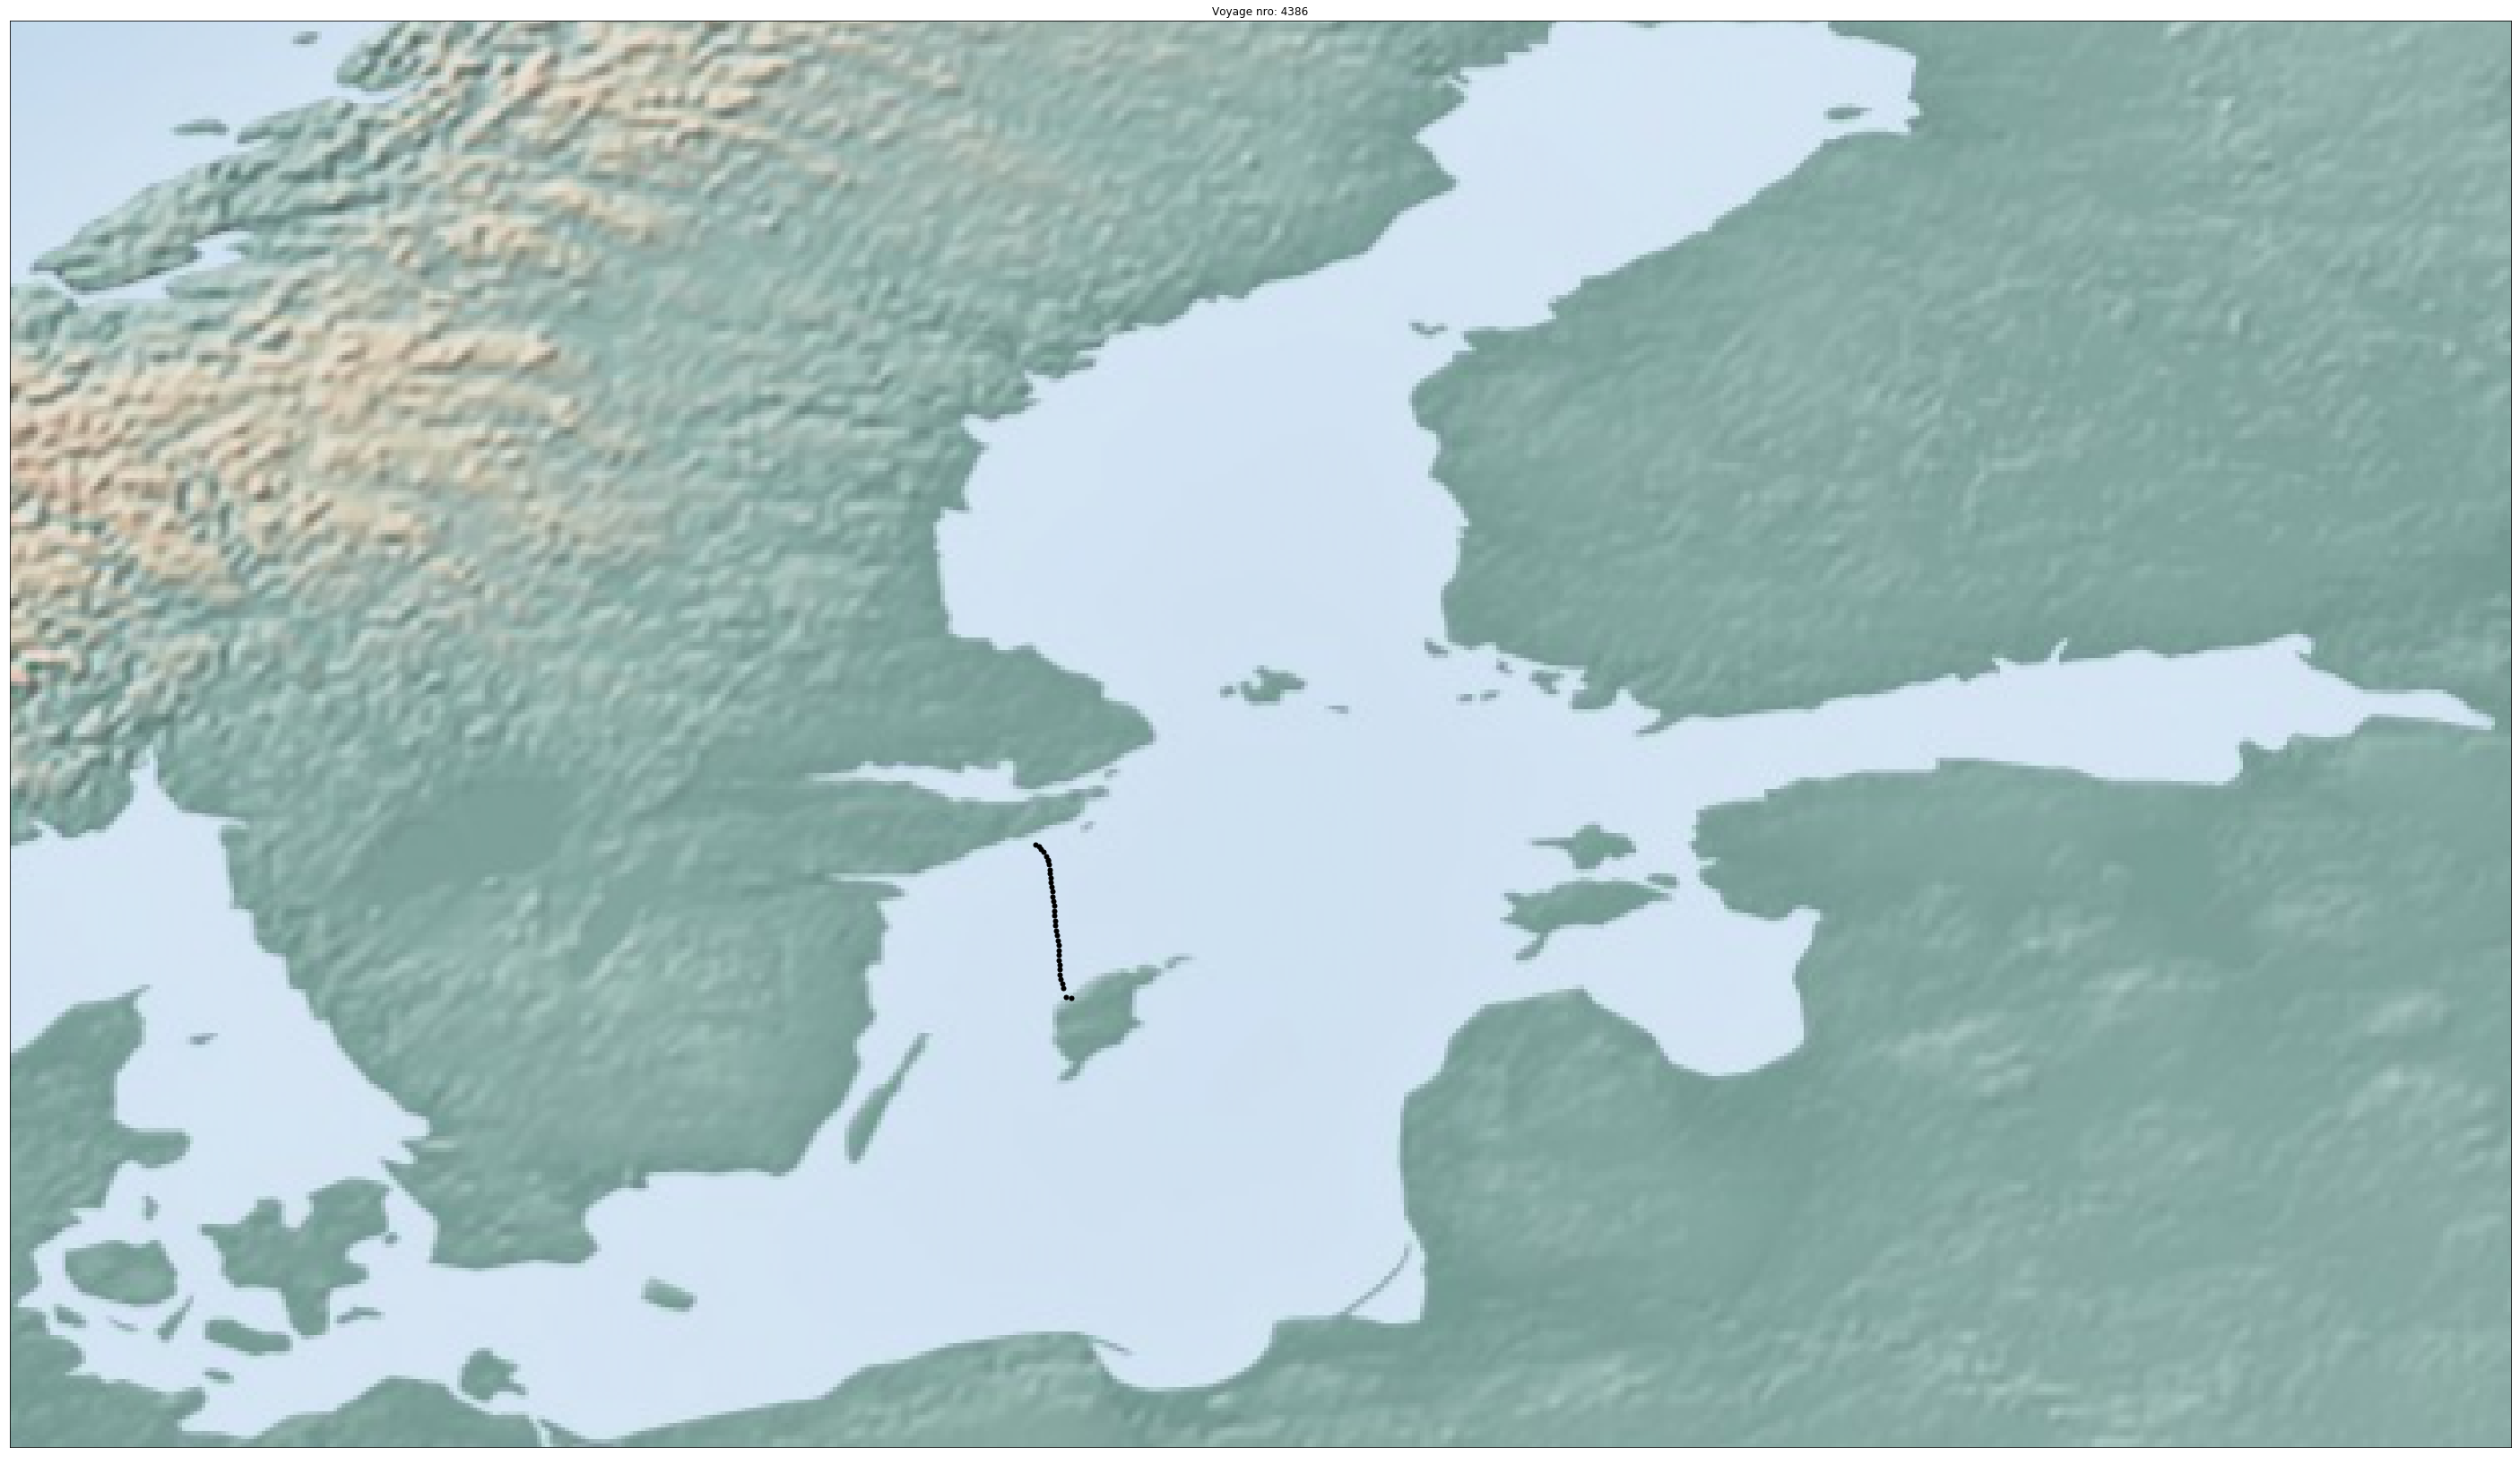

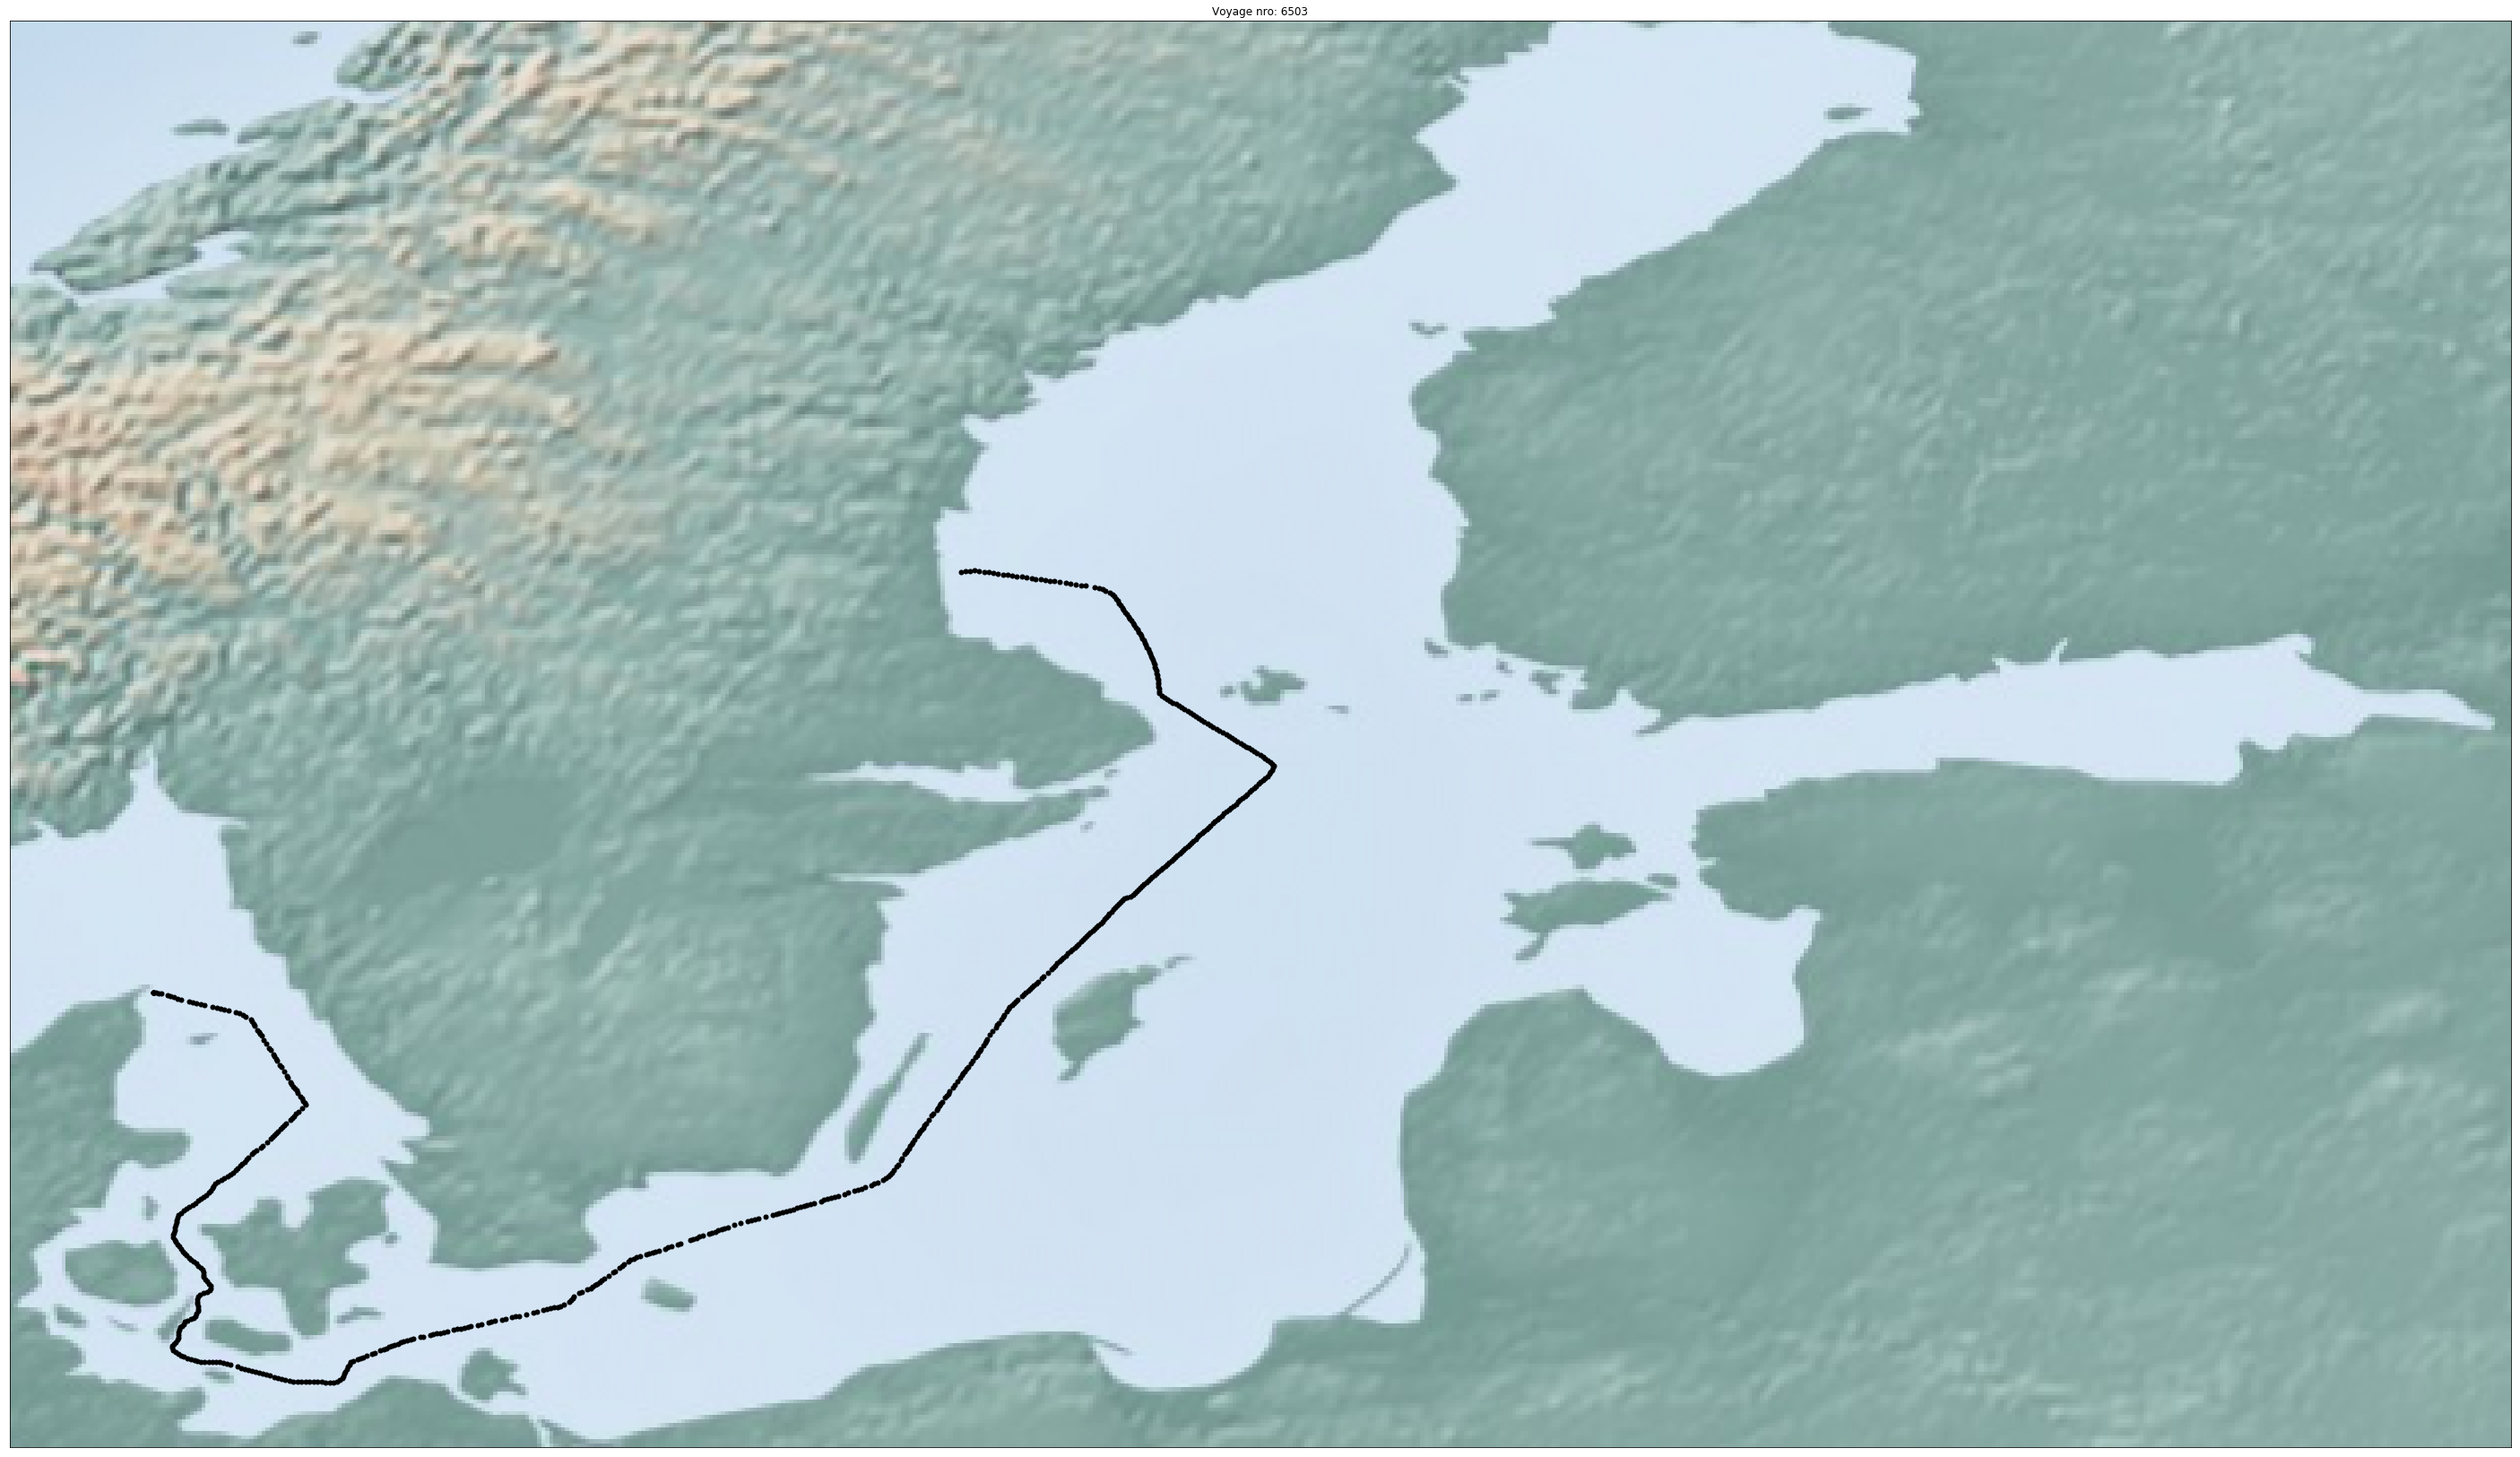

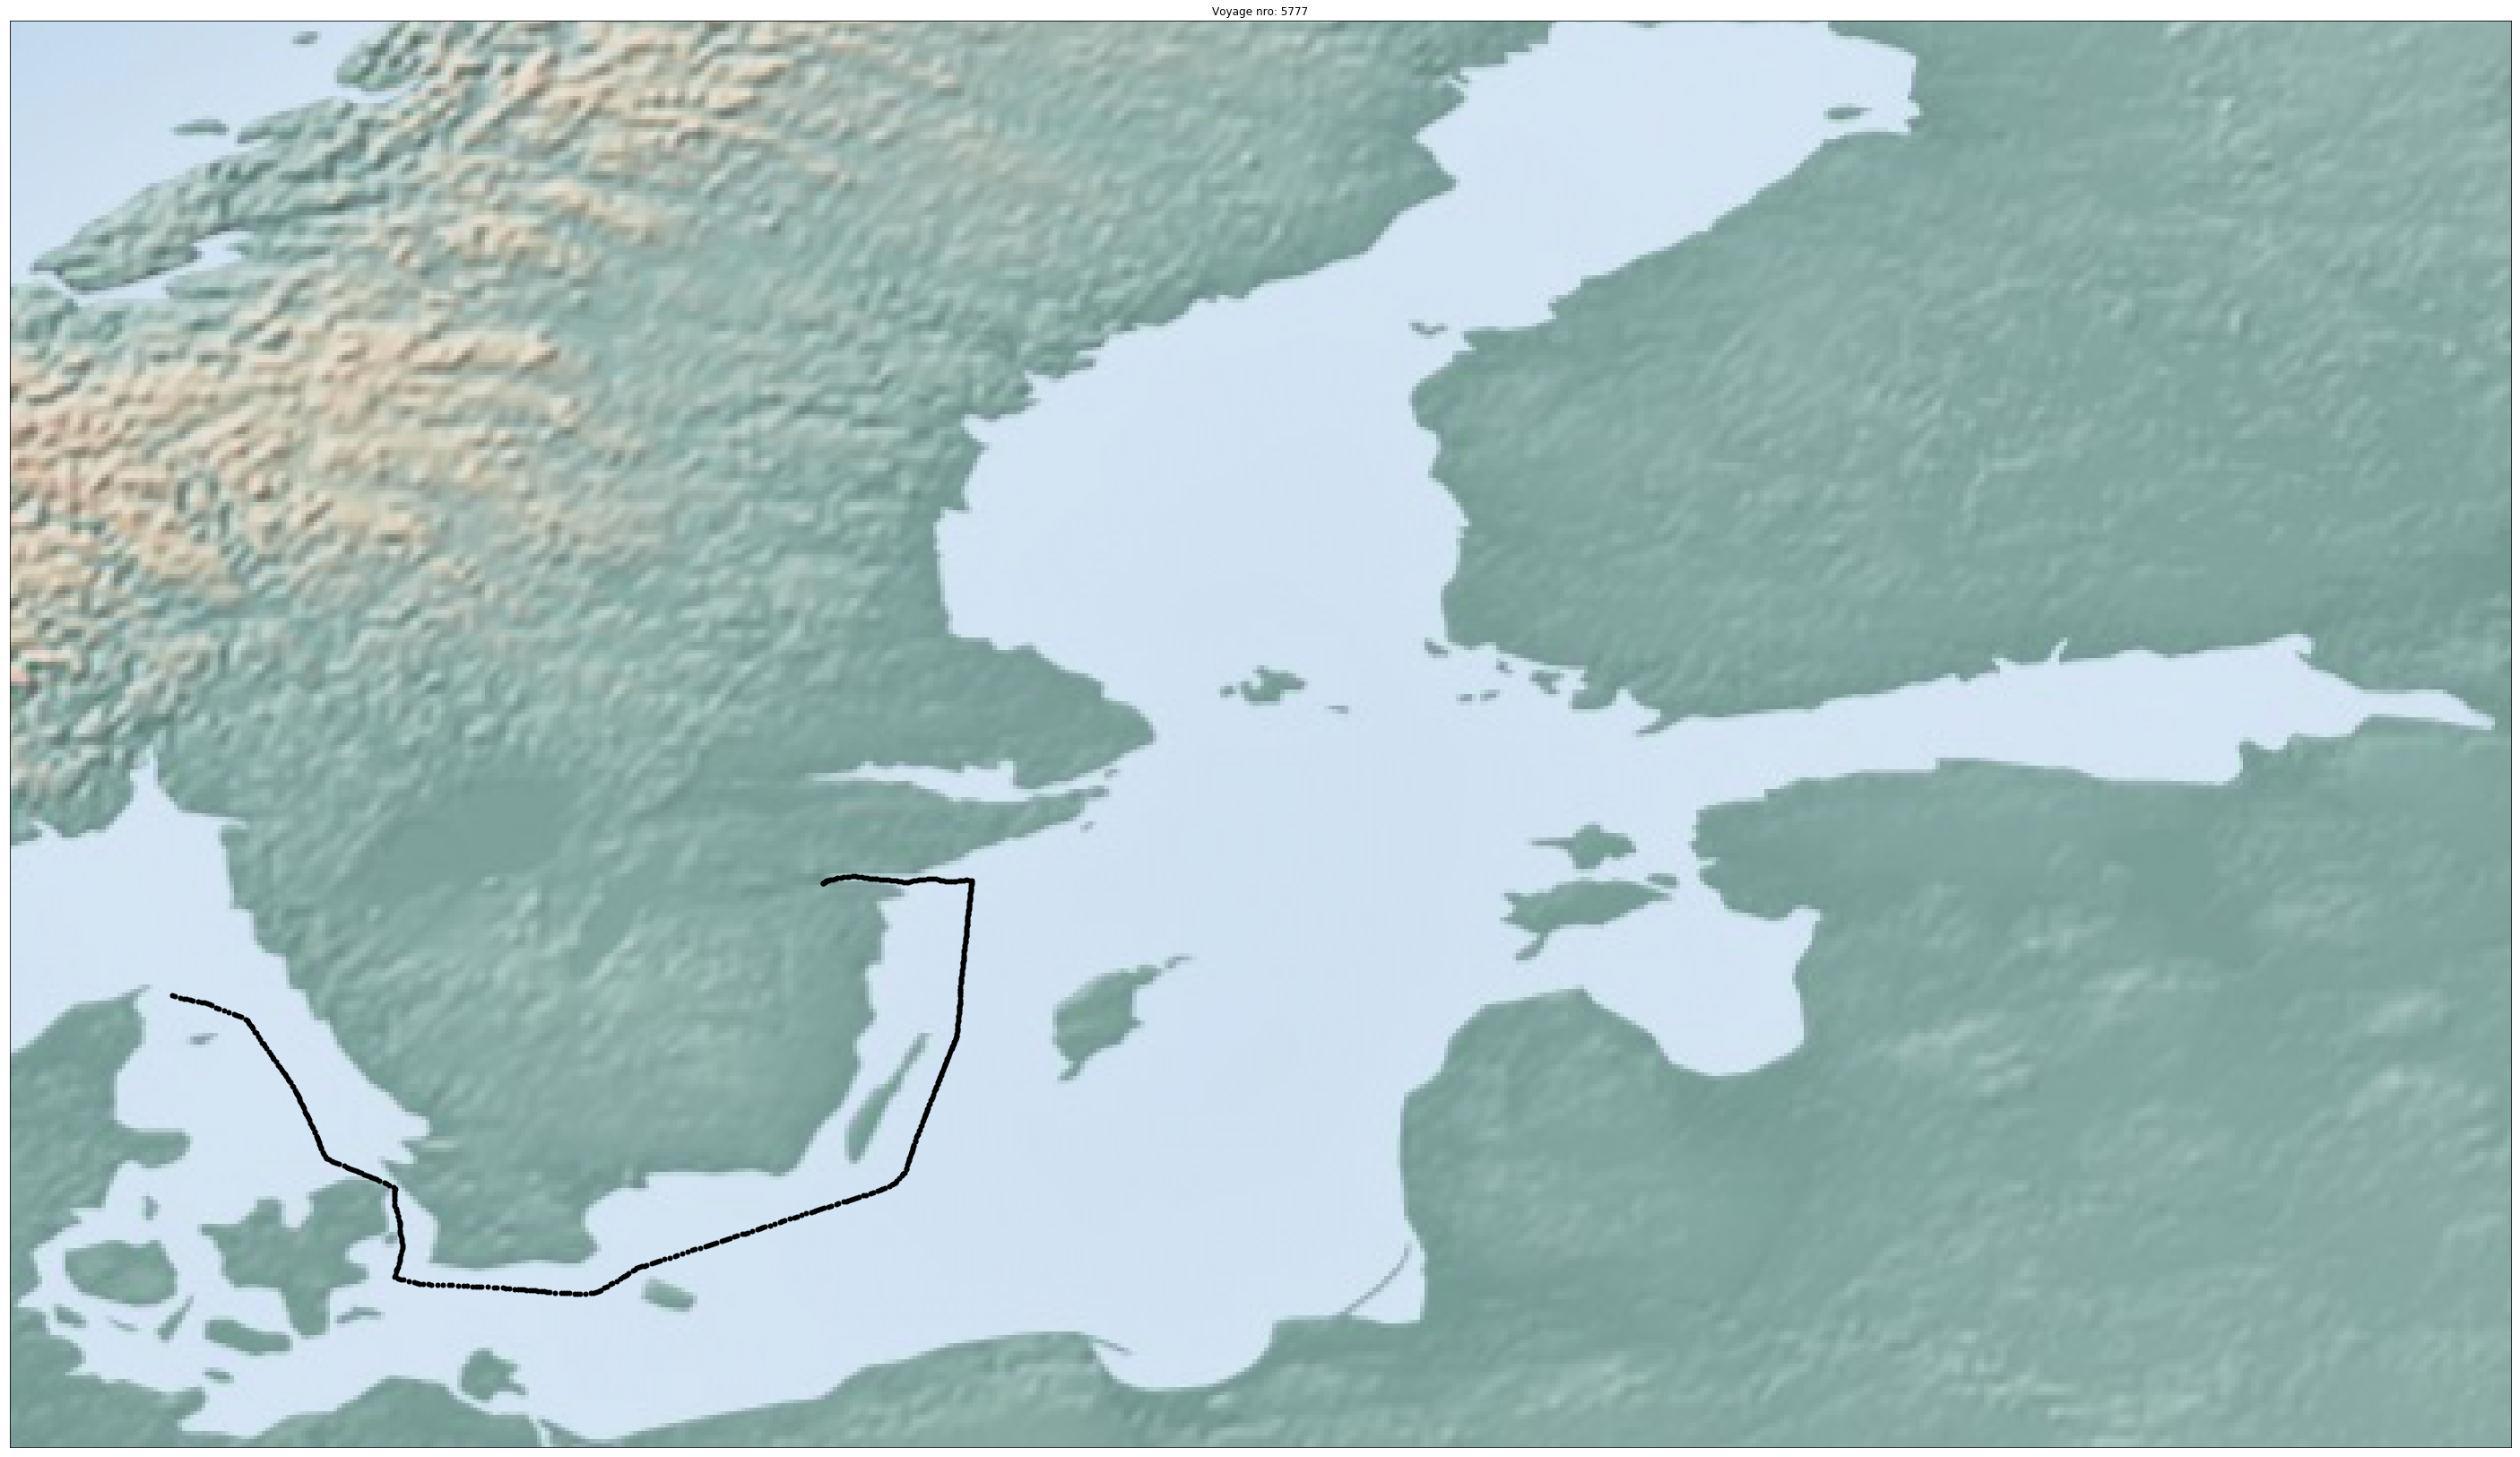

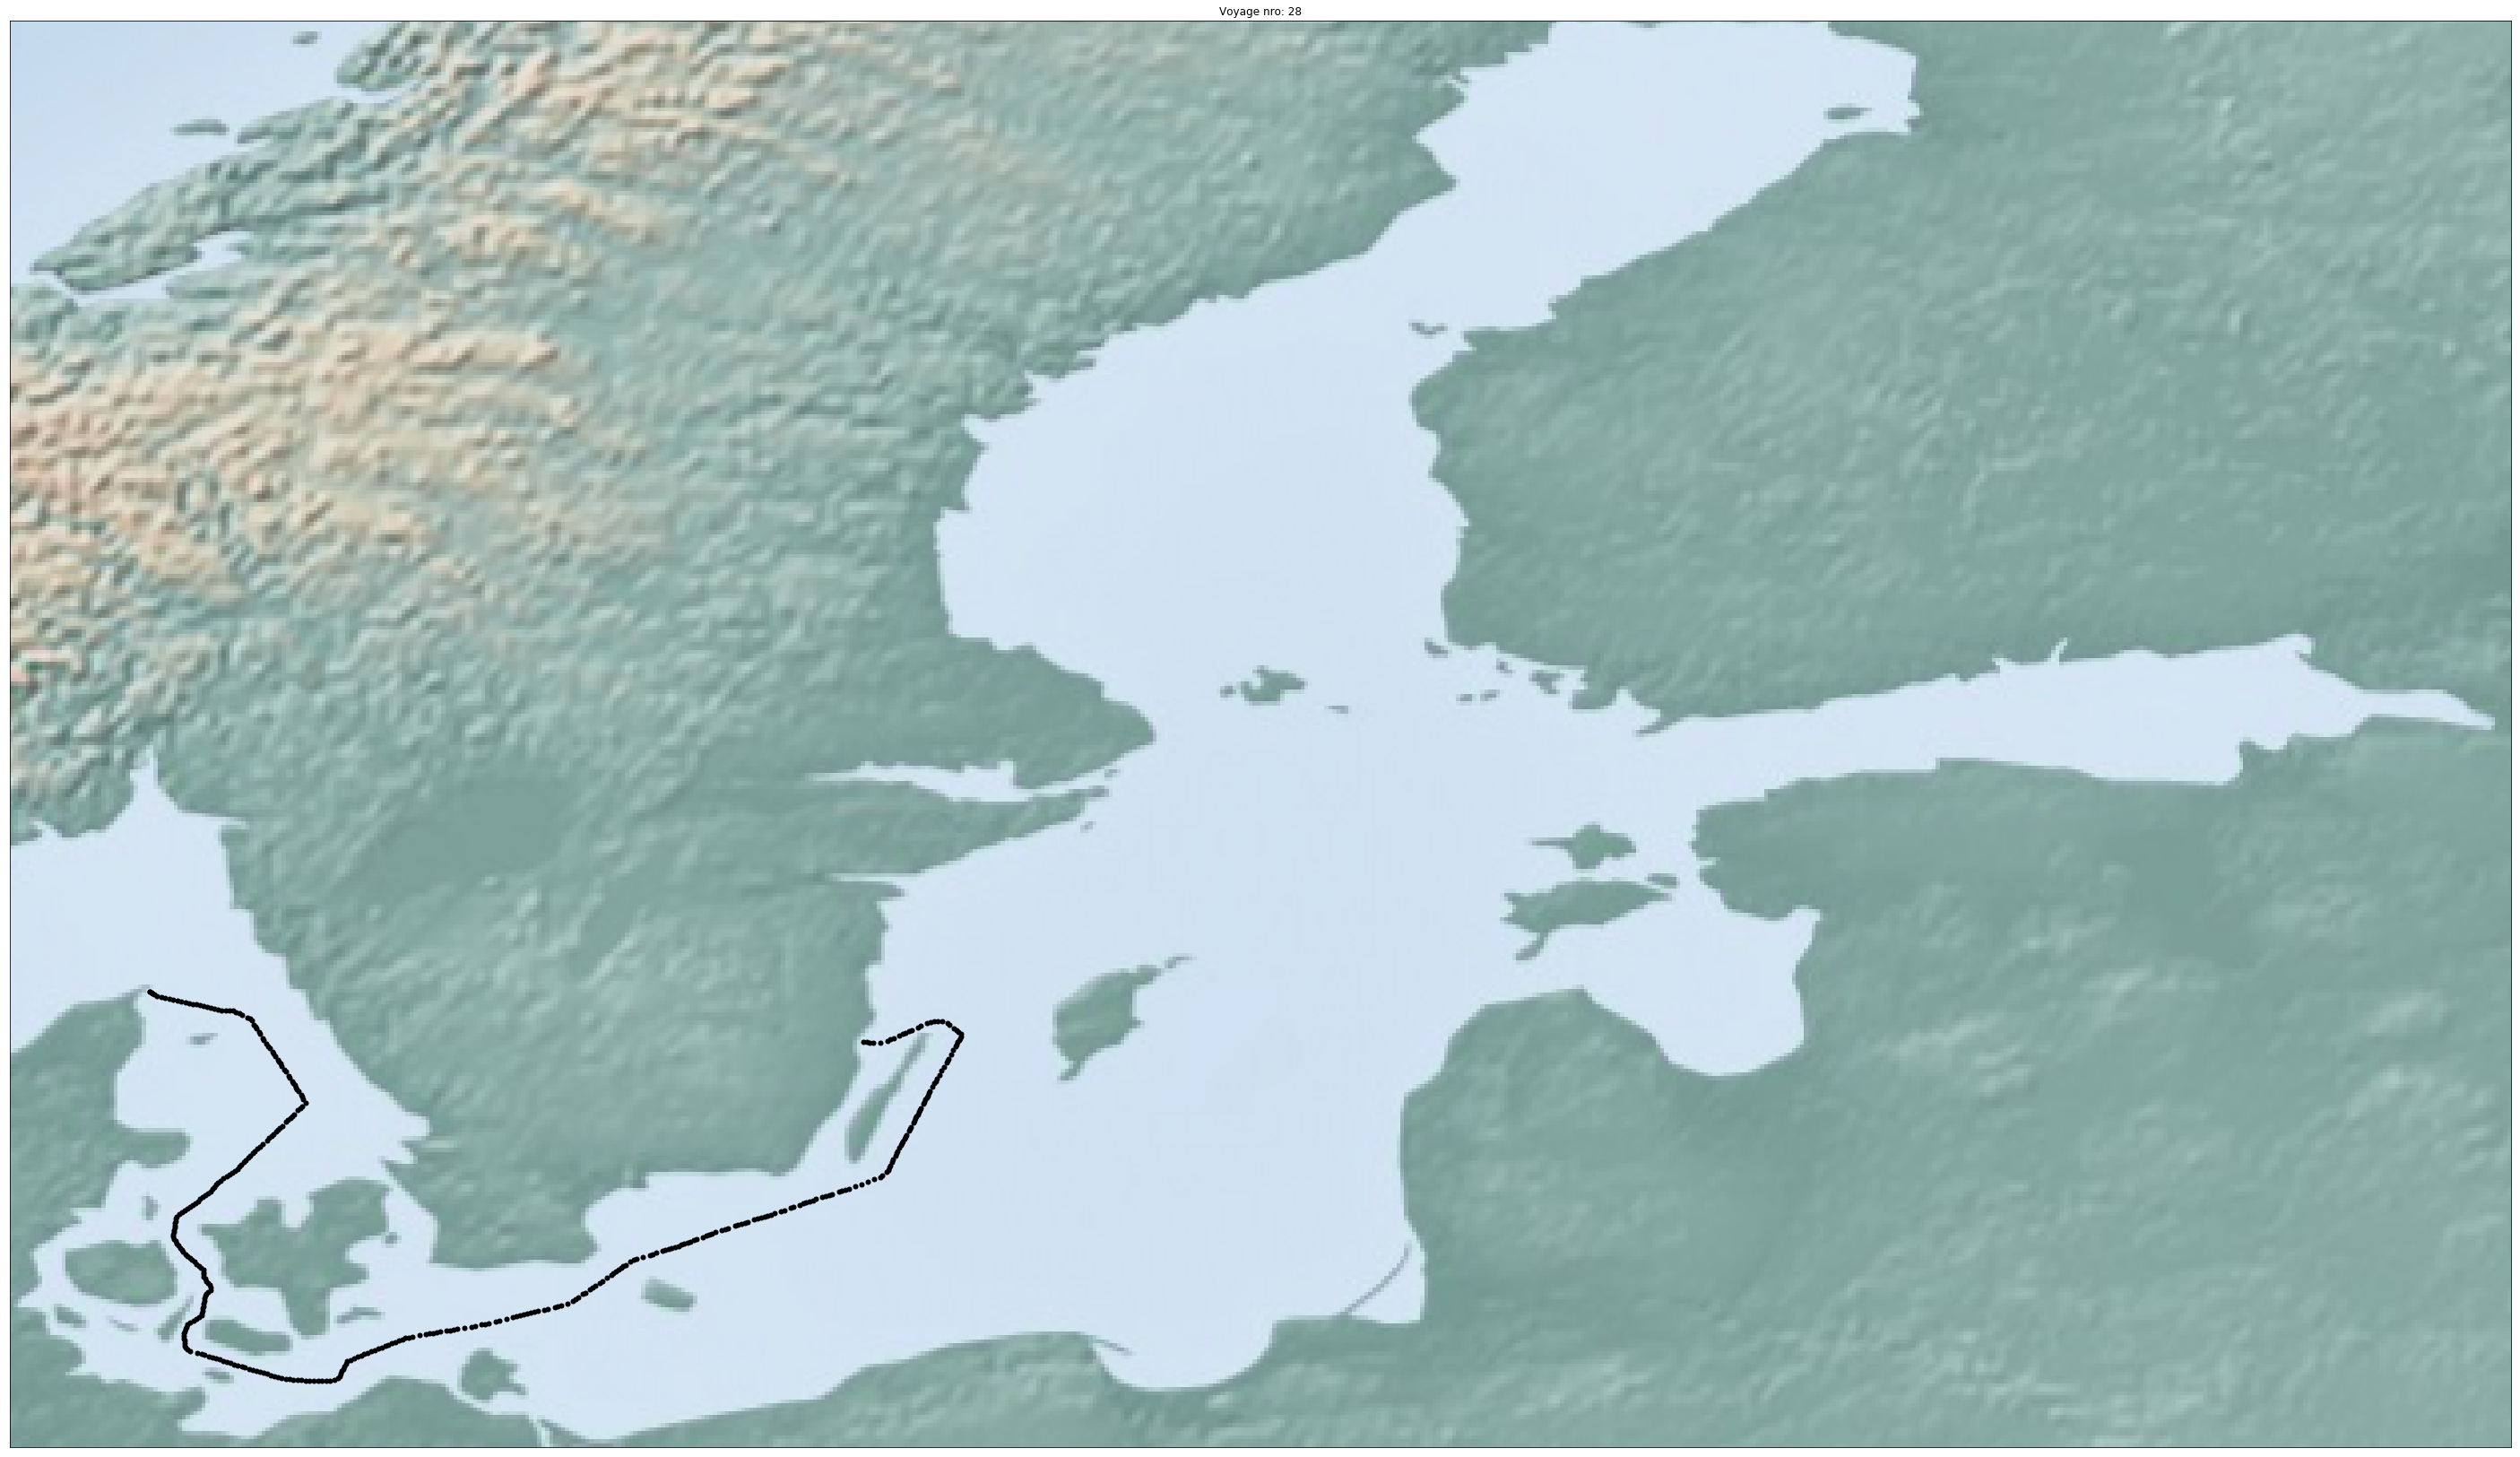

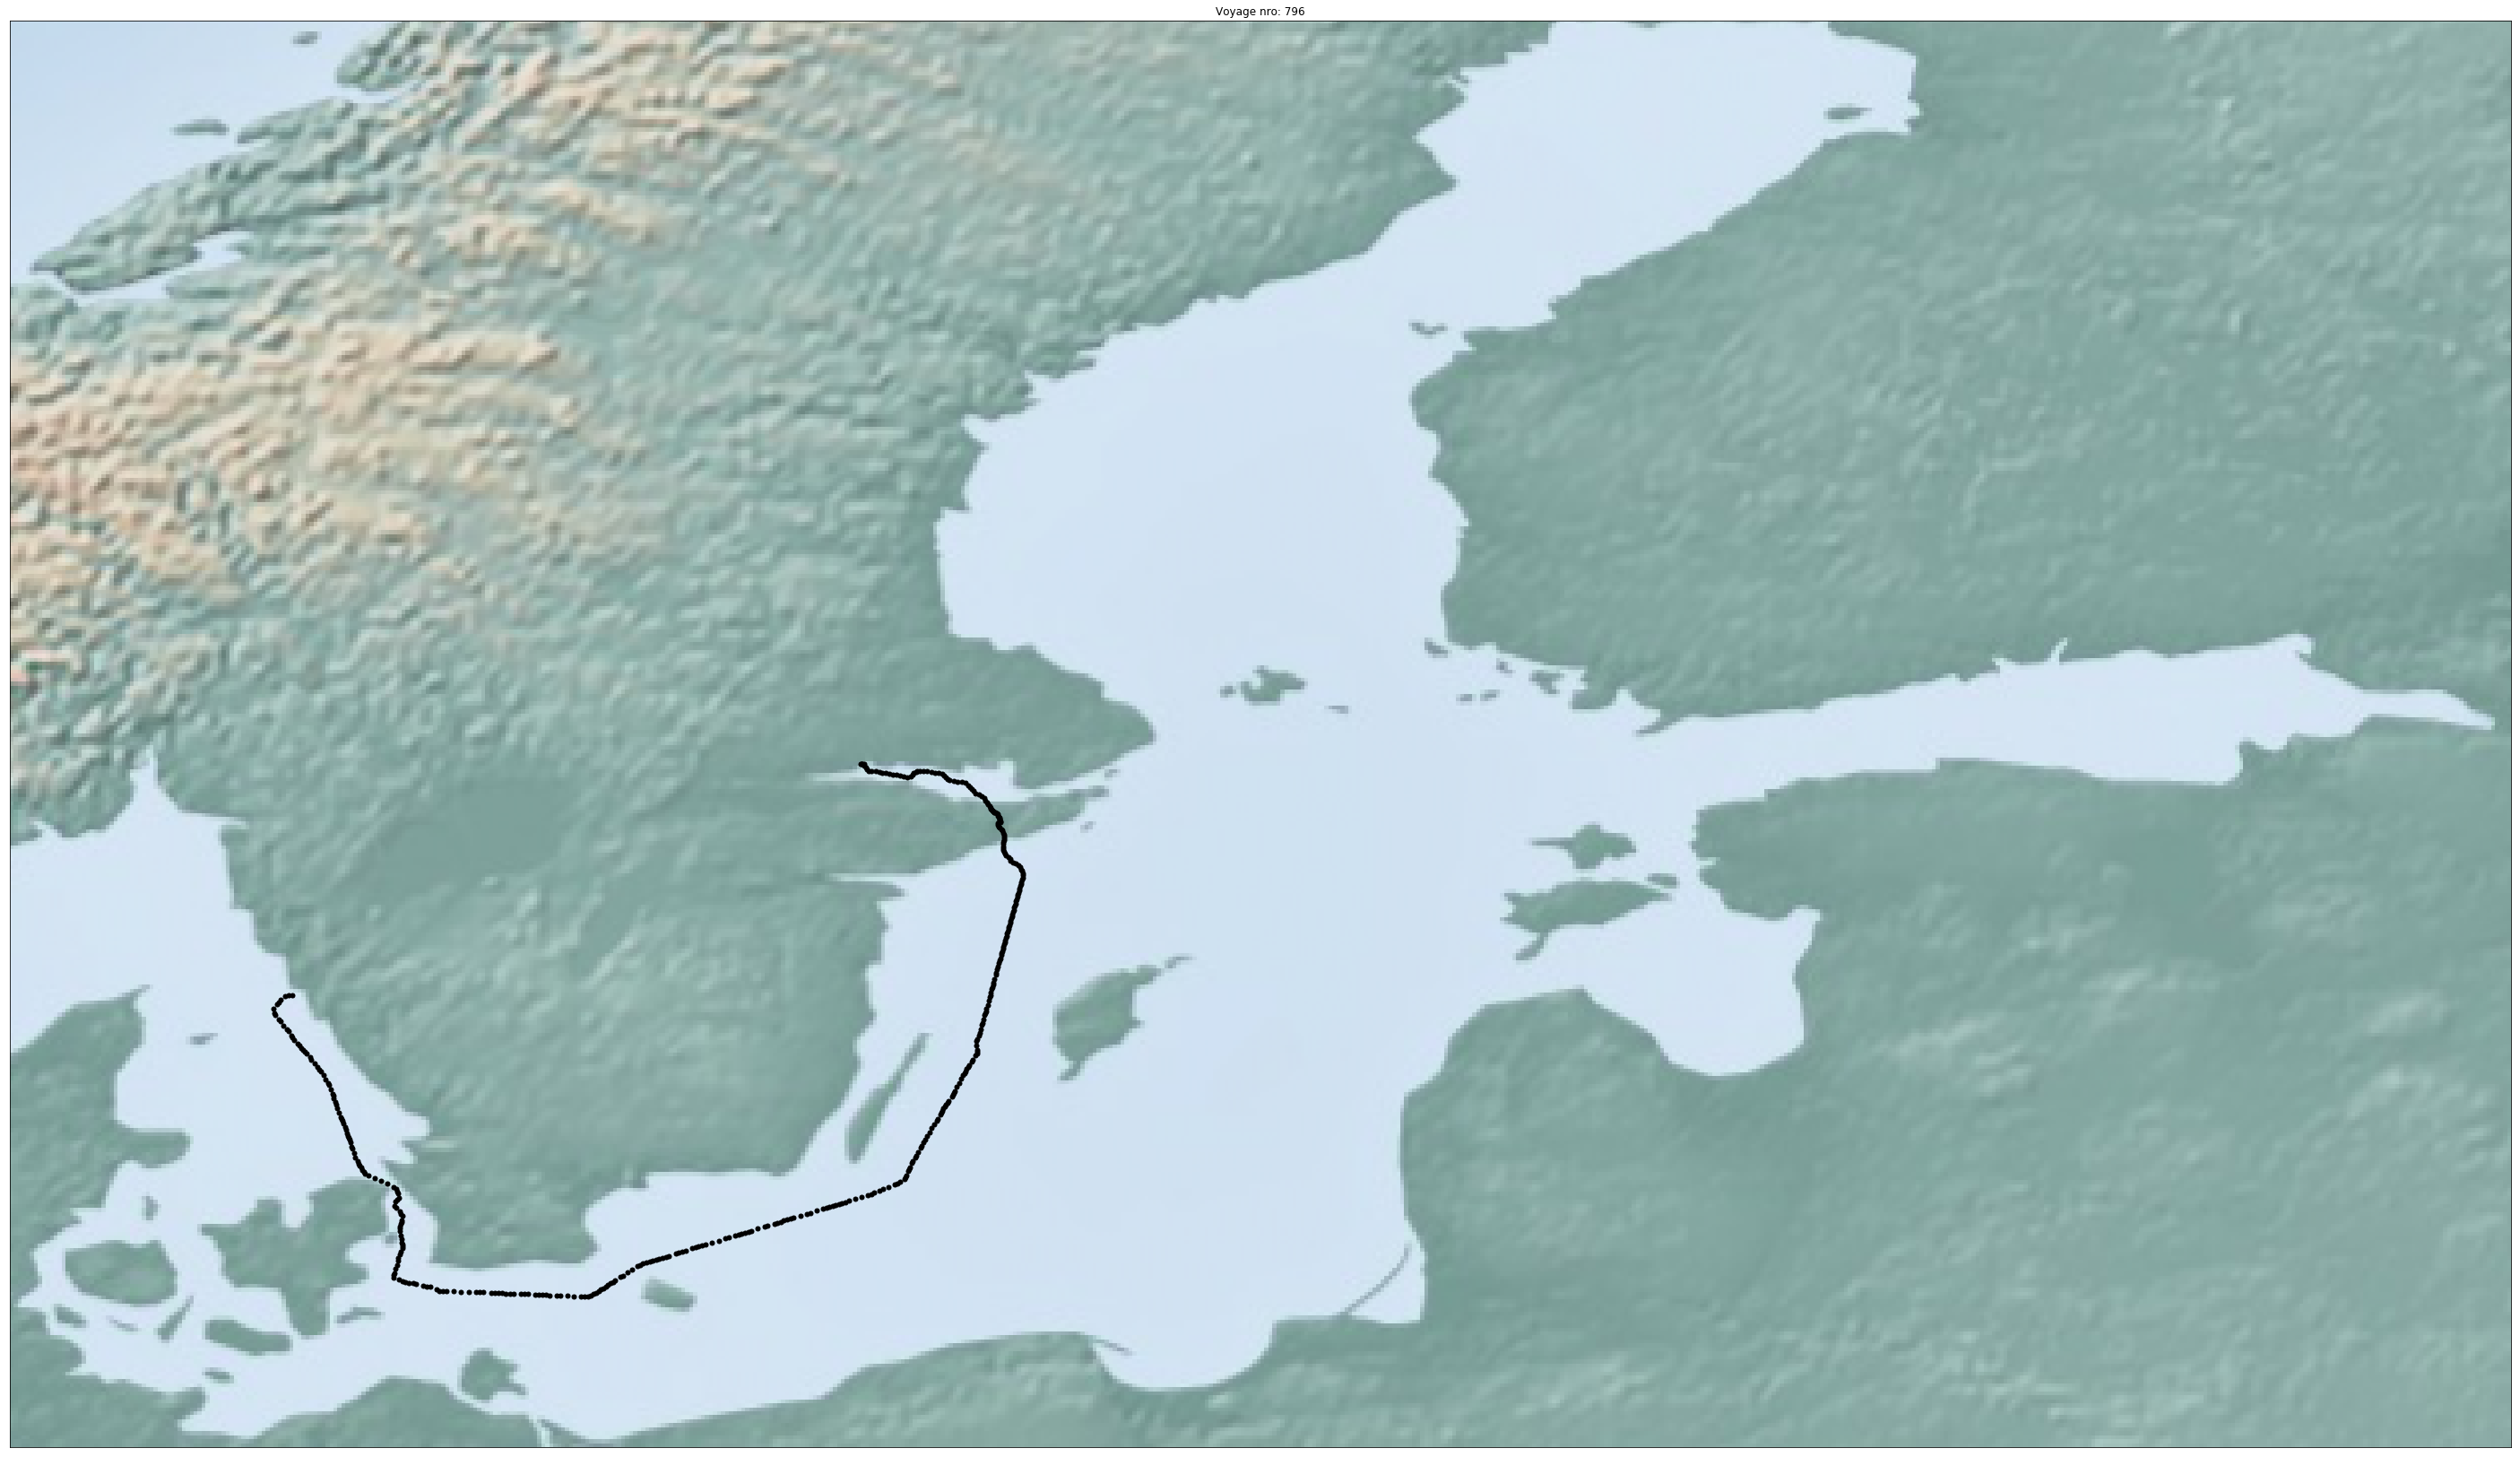

In [21]:
# Visualize routes with big differences
voyages_with_differences = df_summer[(df_summer.difference < 200)].voyage.values

voyages_with_differences = df_summer[(df_summer.difference < 200)].sort_values(by=['difference']).tail(5).voyage.values

for voyage in voyages_with_differences:
    plot_route(test_voyages_summer, voyage)

In [22]:
len(summer_filtered.voyage.drop_duplicates())

2542

In [23]:
import fiona
import pyproj
from shapely.geometry import shape
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point

#sea_areas = MultiPolygon([shape(pol['geometry']) for pol in fiona.open('data/shapes/HELCOM_subbasins_2018.shp')])
for pol in fiona.open('data/shapes/HELCOM_subbasins_2018.shp'):
    pol

In [24]:
#len(test_filtered)

In [25]:
test_filtered = df_summer[~df_summer.voyage.isin(remove_summer)]
test_filtered = test_filtered[~test_filtered.voyage.isin(remove_summer_short)]
len(test_filtered)

2542

In [26]:
#test_filtered[test_filtered.voyage.isin([15,1612,2565,2862,2889,3410,3635,3738,5160,5171,
#                                       505, 2289, 2401,2919,3109,3467,3525,3547,5170,5661,6285, 505, 2289, 2401,2919,3109,3467,3525,3547,5170,5661,6285
#                 ,131,939,977,1411,1607,2287,2384,2384,2655,3122,3320,3436,5187,5763
#                 ,594, 1008, 2954, 3364, 3469, 3687, 5186, 5212, 5821])][['start_port']].drop_duplicates().values.tolist()



In [ ]:
import json
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open('data/shapes/sea_areas_fewer_areas.geojson') as f:
    sea_areas = json.load(f)

# construct point based on lon/lat returned by geocoder
point = Point(-122.7924463, 45.4519896)

def get_sea_area(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['id']
    return -1

def get_sea_area_name(sea_areas, lat, lon):
    point = Point(lon, lat)
    # check each polygon to see if it contains the point
    for feature in sea_areas['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'Other'

In [27]:
test_filtered['sea_area'] = test_filtered.apply(lambda row: get_sea_area(sea_areas, row.end_lat, row.end_lon), axis=1)
test_filtered['sea_area_name'] = test_filtered.apply(lambda row: get_sea_area_name(sea_areas, row.end_lat, row.end_lon), axis=1)

test_filtered.head(10)

voyage  voyage_length  start_end_length  difference  travel_time  \
0        0     342.152985        265.266993   28.984380  1261.983333   
1        1     328.543703        267.555153   22.794758  1213.000000   
3        3     333.517370        265.828471   25.463374  1108.500000   
7        7     671.722033        619.921732    8.355942  1985.650000   
8        8     510.880724        507.799098    0.606859  1450.500000   
9        9     859.361669        628.094938   36.820346  2586.916667   
10      10     411.269598        342.830859   19.962829  1483.833333   
11      11     661.976479        421.112620   57.197017  2507.533333   
13      13     611.062447        443.133121   37.895910  2371.150000   
14      14     393.001082        331.910305   18.405809  1366.066667   

   vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
0           GC   4.500686  54.049413  14.210685  54.370788  10.168035   
1           GC   4.519645  54.044675  14.218467  54.365598  10.140680   
3           GC   5.032994  54.057218  14.197835  54.365183  10.143317   
7           GC   5.660098  59.163938  10.955635  53.895317  14.270618   
8           GC   5.855042  54.010792  14.289272  56.517318  20.995322   
9           GC   5.537360  56.510223  20.838658  57.690312  10.657918   
10          GC   4.595946  54.439715  18.663113  57.264977  16.462285   
11          GC   4.398494  57.273695  16.566005  55.477253  10.541425   
13          GC   4.287333  56.609257  16.347660  55.492052   9.494127   
14          GC   4.801574  53.974982  11.340805  56.889288  12.479425   

    start_port  end_port  sea_area                 sea_area_name  
0         1182      6652        -1                         Other  
1         1182      6652        -1                         Other  
3         1182      6652        -1                         Other  
7        34840       631        11  Arkona Basin & Bomholm Basin  
8         1182     13696         8                 Gotland Basin  
9        13696     26272        -1                         Other  
10        1242     19991         8                 Gotland Basin  
11       19991     13011        11  Arkona Basin & Bomholm Basin  
13       16124     13826        11  Arkona Basin & Bomholm Basin  
14        2803     19942        -1                         Other

In [28]:
test_filtered[test_filtered.voyage.isin([2893])][['start_port']].drop_duplicates().values.tolist()

[[13696]]

In [29]:
len(test_filtered.voyage)

2542

In [30]:
test_filtered[['sea_area_name', 'sea_area']].drop_duplicates().values

array([['Other', -1],
       ['Arkona Basin & Bomholm Basin', 11],
       ['Gotland Basin', 8],
       ['Bothnian Sea & The Quark', 3],
       ['Gulf of Riga', 7],
       ['Gdansk Basin', 10],
       ['Åland Sea', 4],
       ['Bothnian Bay', 1],
       ['Gulf of Finland', 5],
       ['Northern Baltic Proper', 6],
       ['St. Petersburg', 999],
       ['Saimaa', 13]], dtype=object)

In [36]:
#problematic_ports = [18672,28273,977,1061,19223,25183, 967]
problematic_start_ports = [31609,  9994,  11063,  28273,  33677, 17151,  1067,  4081177,  7546461,  7546458,  17602,  1025,  8616614,  1095,  921,  6652,  14106,  631,  913,  3200539,  16217
                          ,26272,991, 13011, 13826, 3640, 1077, 14171, 2994047, 13696]
# 78, 
faulty_voyages = [505, 2289, 2401,2919,3109,3467,3525,3547,5170,5661,6285, 505, 2289, 2401,2919,3109,3467,3525,3547,5170,5661,6285
                 ,131,939,977,1411,1607,2287,2384,2384,2655,3122,3320,3436,5187,5763
                 ,594, 1008, 2954, 3364, 3469, 3687, 5186, 5212, 5821, 968, 5717, 3653, 2369, 2940]

test_filtered = test_filtered[~test_filtered.voyage.isin(faulty_voyages)]
test_filtered = test_filtered[~test_filtered.start_port.isin(problematic_start_ports)]
test_filtered = test_filtered[~test_filtered.end_port.isin(problematic_start_ports)]

validation_set_voyages = test_filtered.head(0)
for sea_area in test_filtered.sea_area.drop_duplicates().values:
    if sea_area == 999:
        continue
    print(sea_area)
    validation_set_voyages = validation_set_voyages.append(test_filtered[(test_filtered.sea_area == sea_area)].sample(n=30))
    
#    for vessel_type in test_filtered.vessel_type.drop_duplicates().values:
#        print(sea_area, vessel_type)
#        test_test_set = test_test_set.append(test_filtered[(test_filtered.sea_area == sea_area) & (test_filtered.vessel_type == vessel_type)].sample(n=5))
#test_filtered.sample(n=3)
print(len(validation_set_voyages.voyage))
validation_set_voyages[validation_set_voyages.sea_area == 13].head()
validation_set_voyages.describe()

8
-1
3
10
1
7
6
11
5
4
13
330


voyage  voyage_length  start_end_length  difference  travel_time  \
count   330.000000     330.000000        330.000000  330.000000   330.000000   
mean   3299.927273     516.031082        408.732554   26.281408  1422.086162   
std    1756.757853     343.622339        256.768676   31.315226  1013.877433   
min      14.000000       9.368543          9.184511    0.453766    67.950000   
25%    2254.250000     284.000496        259.338044    5.739473   638.200000   
50%    2996.000000     404.163412        324.668310   14.700501  1118.750000   
75%    4895.000000     635.502617        498.671228   31.509834  1857.175000   
max    6576.000000    2029.400648       1317.256220  173.280797  5353.933333   

        avg_speed   start_lat   start_lon     end_lat     end_lon  \
count  330.000000  330.000000  330.000000  330.000000  330.000000   
mean     6.296045   58.280711   19.560852   59.019501   20.394468   
std      1.895353    2.741216    5.166746    3.079901    4.677818   
min      1.564000   53.974982    9.925703   53.893155    9.860833   
25%      5.034446   55.930637   15.776182   56.953202   17.957656   
50%      5.986336   58.913263   18.847685   58.913000   20.344804   
75%      7.939009   60.233875   23.876544   60.685902   24.076981   
max     10.909583   65.748367   28.903347   65.790930   29.753345   

         start_port      end_port    sea_area  
count  3.300000e+02  3.300000e+02  330.000000  
mean   8.414657e+05  1.045565e+06    6.090909  
std    2.381435e+06  2.493300e+06    4.083949  
min    9.000000e+00  9.230000e+02   -1.000000  
25%    1.043000e+03  1.007000e+03    3.000000  
50%    2.345000e+03  2.345000e+03    6.000000  
75%    2.139400e+04  1.976225e+04   10.000000  
max    1.583330e+07  8.616642e+06   13.000000

In [38]:
validation_set_summer = summer_filtered[summer_filtered.voyage.isin(validation_set_voyages.voyage.values)]
validation_set_summer.voyage.drop_duplicates().describe()
validation_set_summer['end_port_sea_area'] = validation_set_summer.apply(lambda row: get_sea_area(sea_areas, row.end_lat, row.end_lon), axis=1)
#validation_set_summer.to_csv('validation_set_summer_long_complete.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
validation_set_summer.head()

timestamp       mmsi        lat        lon  speed  node  \
2741 2019-06-07 11:27:49  209014000  53.974982  11.340805   4.63   849   
2742 2019-06-07 11:35:43  209014000  53.992868  11.331420   4.63   849   
2743 2019-06-07 11:41:43  209014000  54.007890  11.331562   4.63   849   
2744 2019-06-07 11:47:53  209014000  54.018665  11.345753   4.42   849   
2745 2019-06-07 11:52:59  209014000  54.020092  11.367012   4.53   849   

     vessel_type  start_port  end_port    end_lat    end_lon  \
2741          GC        2803     19942  56.889288  12.479425   
2742          GC        2803     19942  56.889288  12.479425   
2743          GC        2803     19942  56.889288  12.479425   
2744          GC        2803     19942  56.889288  12.479425   
2745          GC        2803     19942  56.889288  12.479425   

                     ata                 atd  in_port  voyage  \
2741 2019-06-08 10:13:53 2019-06-07 11:27:49    False      14   
2742 2019-06-08 10:13:53 2019-06-07 11:27:49    False      14   
2743 2019-06-08 10:13:53 2019-06-07 11:27:49    False      14   
2744 2019-06-08 10:13:53 2019-06-07 11:27:49    False      14   
2745 2019-06-08 10:13:53 2019-06-07 11:27:49    False      14   

      end_port_sea_area  
2741                 -1  
2742                 -1  
2743                 -1  
2744                 -1  
2745                 -1

In [37]:
test_voyages_winter = pd.read_csv('test_set_winter_voyages_extended.csv', index_col=0, parse_dates = ['timestamp', 'ata', 'atd'])

In [38]:
test_voyages_winter['course'] = -1
north_test = test_voyages_winter
voyages = north_test.groupby('voyage')
first_rows = []
for voyage, observations in voyages:
    if len(observations) is 1:
        continue
    course = shortest_path.angleFromCoordinatesInDeg([observations.iloc[0].lat, observations.iloc[0].lon], [observations.iloc[1].lat, observations.iloc[1].lon])
    row = observations.iloc[1]
    row.course = course
    first_rows.append(row)

first_rows = pd.DataFrame(data=first_rows, columns=north_test.columns)
first_rows.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


timestamp       mmsi        lat        lon  speed   node  \
1   2019-02-10 04:18:29  205723000  60.210510  18.850577   6.33   9185   
25  2019-02-15 12:51:35  205723000  56.504810  20.813577   5.66   3396   
368 2019-03-05 20:31:14  205723000  55.502682   9.615737   3.60   3464   
742 2019-03-26 00:40:21  205723000  55.454105  12.200352   1.85   2790   
995 2019-02-05 12:04:00  209185000  61.622335  17.224340   5.20  11387   

    vessel_type iceclass  start_port  end_port    end_lat    end_lon  \
1            GC       IA    10559054  10560147  60.169250  18.487133   
25           GC       IA       13696      6652  54.365350  10.142517   
368          GC       IA       13826      8176  55.656533  21.156968   
742          GC       IA         985     13696  56.533742  20.997185   
995          GC       IA     3012222      1031  63.713705  22.691090   

                    ata                 atd  in_port  voyage      course  
1   2019-02-10 06:17:58 2019-02-10 04:13:19    False       0  325.877416  
25  2019-02-17 02:43:57 2019-02-15 12:45:35    False       1  251.350801  
368 2019-03-07 13:45:12 2019-03-05 20:25:15    False       2   69.646777  
742 2019-03-27 06:00:26 2019-03-26 00:35:18    False       3   85.592879  
995 2019-02-06 08:53:31 2019-02-05 11:58:29    False       4   92.121192

In [39]:
north_voyages = first_rows[(first_rows.end_lat > 64.8) | (first_rows.lat > 64.8)].voyage.drop_duplicates().values

In [40]:
test_voyages_winter = test_voyages_winter[test_voyages_winter.voyage.isin(north_voyages)]

In [41]:
test_voyages_winter.head()

timestamp       mmsi        lat        lon  speed   node  \
1229 2019-03-20 14:38:32  209185000  61.622468  17.207792   4.78  11387   
1230 2019-03-20 14:44:01  209185000  61.622263  17.241178   5.61  11387   
1231 2019-03-20 14:49:25  209185000  61.622037  17.275425   5.45  11387   
1232 2019-03-20 14:54:42  209185000  61.615038  17.299898   3.96  11387   
1233 2019-03-20 14:59:52  209185000  61.609090  17.316947   3.96  11387   

     vessel_type iceclass  start_port  end_port    end_lat    end_lon  \
1229          GC       IA     3012222       935  65.234498  21.628285   
1230          GC       IA     3012222       935  65.234498  21.628285   
1231          GC       IA     3012222       935  65.234498  21.628285   
1232          GC       IA     3012222       935  65.234498  21.628285   
1233          GC       IA     3012222       935  65.234498  21.628285   

                     ata                 atd  in_port  voyage  course  
1229 2019-03-22 00:08:31 2019-03-20 14:38:32    False       5      -1  
1230 2019-03-22 00:08:31 2019-03-20 14:38:32    False       5      -1  
1231 2019-03-22 00:08:31 2019-03-20 14:38:32    False       5      -1  
1232 2019-03-22 00:08:31 2019-03-20 14:38:32    False       5      -1  
1233 2019-03-22 00:08:31 2019-03-20 14:38:32    False       5      -1

In [42]:
%time df_winter = get_voyage_lengths(test_voyages_winter)

CPU times: user 12.8 s, sys: 122 ms, total: 12.9 s
Wall time: 13.7 s


In [43]:
df_winter.describe()

voyage  voyage_length  start_end_length  difference  travel_time  \
count   86.000000      86.000000         86.000000   86.000000    86.000000   
mean   304.453488    1092.833826        864.828429   32.795182  2902.106977   
std    182.504063     607.486804        498.365587   30.969867  1492.668235   
min      5.000000      80.657340         36.890068    6.986555   275.166667   
25%    134.750000     491.635194        363.569251   17.460748  1644.329167   
50%    338.000000    1084.298650        889.991607   22.363031  3355.325000   
75%    437.750000    1674.111090       1363.415818   34.315136  3834.608333   
max    627.000000    2104.379710       1478.304471  222.367117  6673.816667   

       avg_speed  start_lat  start_lon    end_lat    end_lon    start_port  \
count  86.000000  86.000000  86.000000  86.000000  86.000000  8.600000e+01   
mean    6.126517  62.708318  20.340720  61.447031  19.229399  6.758687e+05   
std     1.158474   4.135838   4.774084   4.614673   5.641238  2.235897e+06   
min     2.851237  54.019082  10.217388  54.365267  10.140200  9.350000e+02   
25%     5.295751  59.099861  19.001377  57.117125  16.460293  9.590000e+02   
50%     5.878233  65.223058  21.648152  63.697748  21.622249  1.027000e+03   
75%     7.049584  65.711904  23.907149  65.546050  24.119887  5.895000e+03   
max     9.458846  65.751138  25.414152  65.790333  27.168600  8.616690e+06   

           end_port  
count  8.600000e+01  
mean   3.974984e+04  
std    3.243843e+05  
min    9.310000e+02  
25%    9.825000e+02  
50%    1.067000e+03  
75%    6.652000e+03  
max    3.012222e+06

In [44]:
#41.96609012556685
#9.781703541608012

print(df_winter.difference.mean())
print(df_winter.difference.median())

32.79518179027072
22.3630310475039


In [45]:
df_winter[df_winter.difference <= 100].describe()

voyage  voyage_length  start_end_length  difference  travel_time  \
count   83.000000      83.000000         83.000000   83.000000    83.000000   
mean   307.686747    1101.903201        881.619311   28.451957  2918.113454   
std    181.450049     592.279001        491.804411   18.799623  1435.249164   
min      5.000000      80.657340         59.265040    6.986555   275.166667   
25%    137.500000     532.239137        415.092737   17.425064  1758.166667   
50%    341.000000    1099.814131        891.214544   21.258298  3381.650000   
75%    437.500000    1673.704658       1363.478007   33.422474  3832.266667   
max    627.000000    1966.384680       1478.304471   93.817951  6673.816667   

       avg_speed  start_lat  start_lon    end_lat    end_lon    start_port  \
count  83.000000  83.000000  83.000000  83.000000  83.000000  8.300000e+01   
mean    6.145164  62.696009  20.352037  61.300198  19.114825  6.999684e+05   
std     1.174694   4.146722   4.730119   4.631106   5.708603  2.272725e+06   
min     2.851237  54.019082  10.217388  54.365267  10.140200  9.350000e+02   
25%     5.267047  59.101238  19.035933  56.334052  14.622139  9.590000e+02   
50%     5.972711  65.222882  21.646683  63.536658  21.621975  1.011000e+03   
75%     7.053276  65.665516  23.639964  65.391000  24.151640  5.138000e+03   
max     9.458846  65.751138  25.414152  65.790333  27.168600  8.616690e+06   

           end_port  
count  8.300000e+01  
mean   4.115172e+04  
std    3.301785e+05  
min    9.310000e+02  
25%    9.990000e+02  
50%    1.073000e+03  
75%    6.652000e+03  
max    3.012222e+06

In [46]:
# 314
remove_winter = set(df_winter[df_winter.difference > 100].voyage.values)
len(remove_winter)

3

In [47]:
#winter_filtered.head()

In [48]:
winter_filtered = test_voyages_winter[~test_voyages_winter.voyage.isin(remove_winter)]
remove_winter_short = set(df_winter[df_winter.voyage_length < 50].voyage.values)
winter_filtered = winter_filtered[~winter_filtered.voyage.isin(remove_winter_short)]
len(remove_winter_short)

0

In [49]:
df_winter[(df_winter.difference > 100)].sort_values(by=['difference']).tail(20)

voyage  voyage_length  start_end_length  difference  travel_time  \
23     164    2104.379710       1034.159077  103.487042  6081.350000   
1       14     302.442179        129.792896  133.019054   949.033333   
69     467     118.921450         36.890068  222.367117   347.400000   

   vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
23           T   5.775720  57.659847  11.767872  65.550527  22.224840   
1         CONT   5.362346  65.745277  24.156438  65.237942  21.621982   
69          GC   5.693788  65.741475  24.158500  65.739822  23.351042   

    start_port  end_port  
23       25183       999  
1         1073       935  
69        1073       959

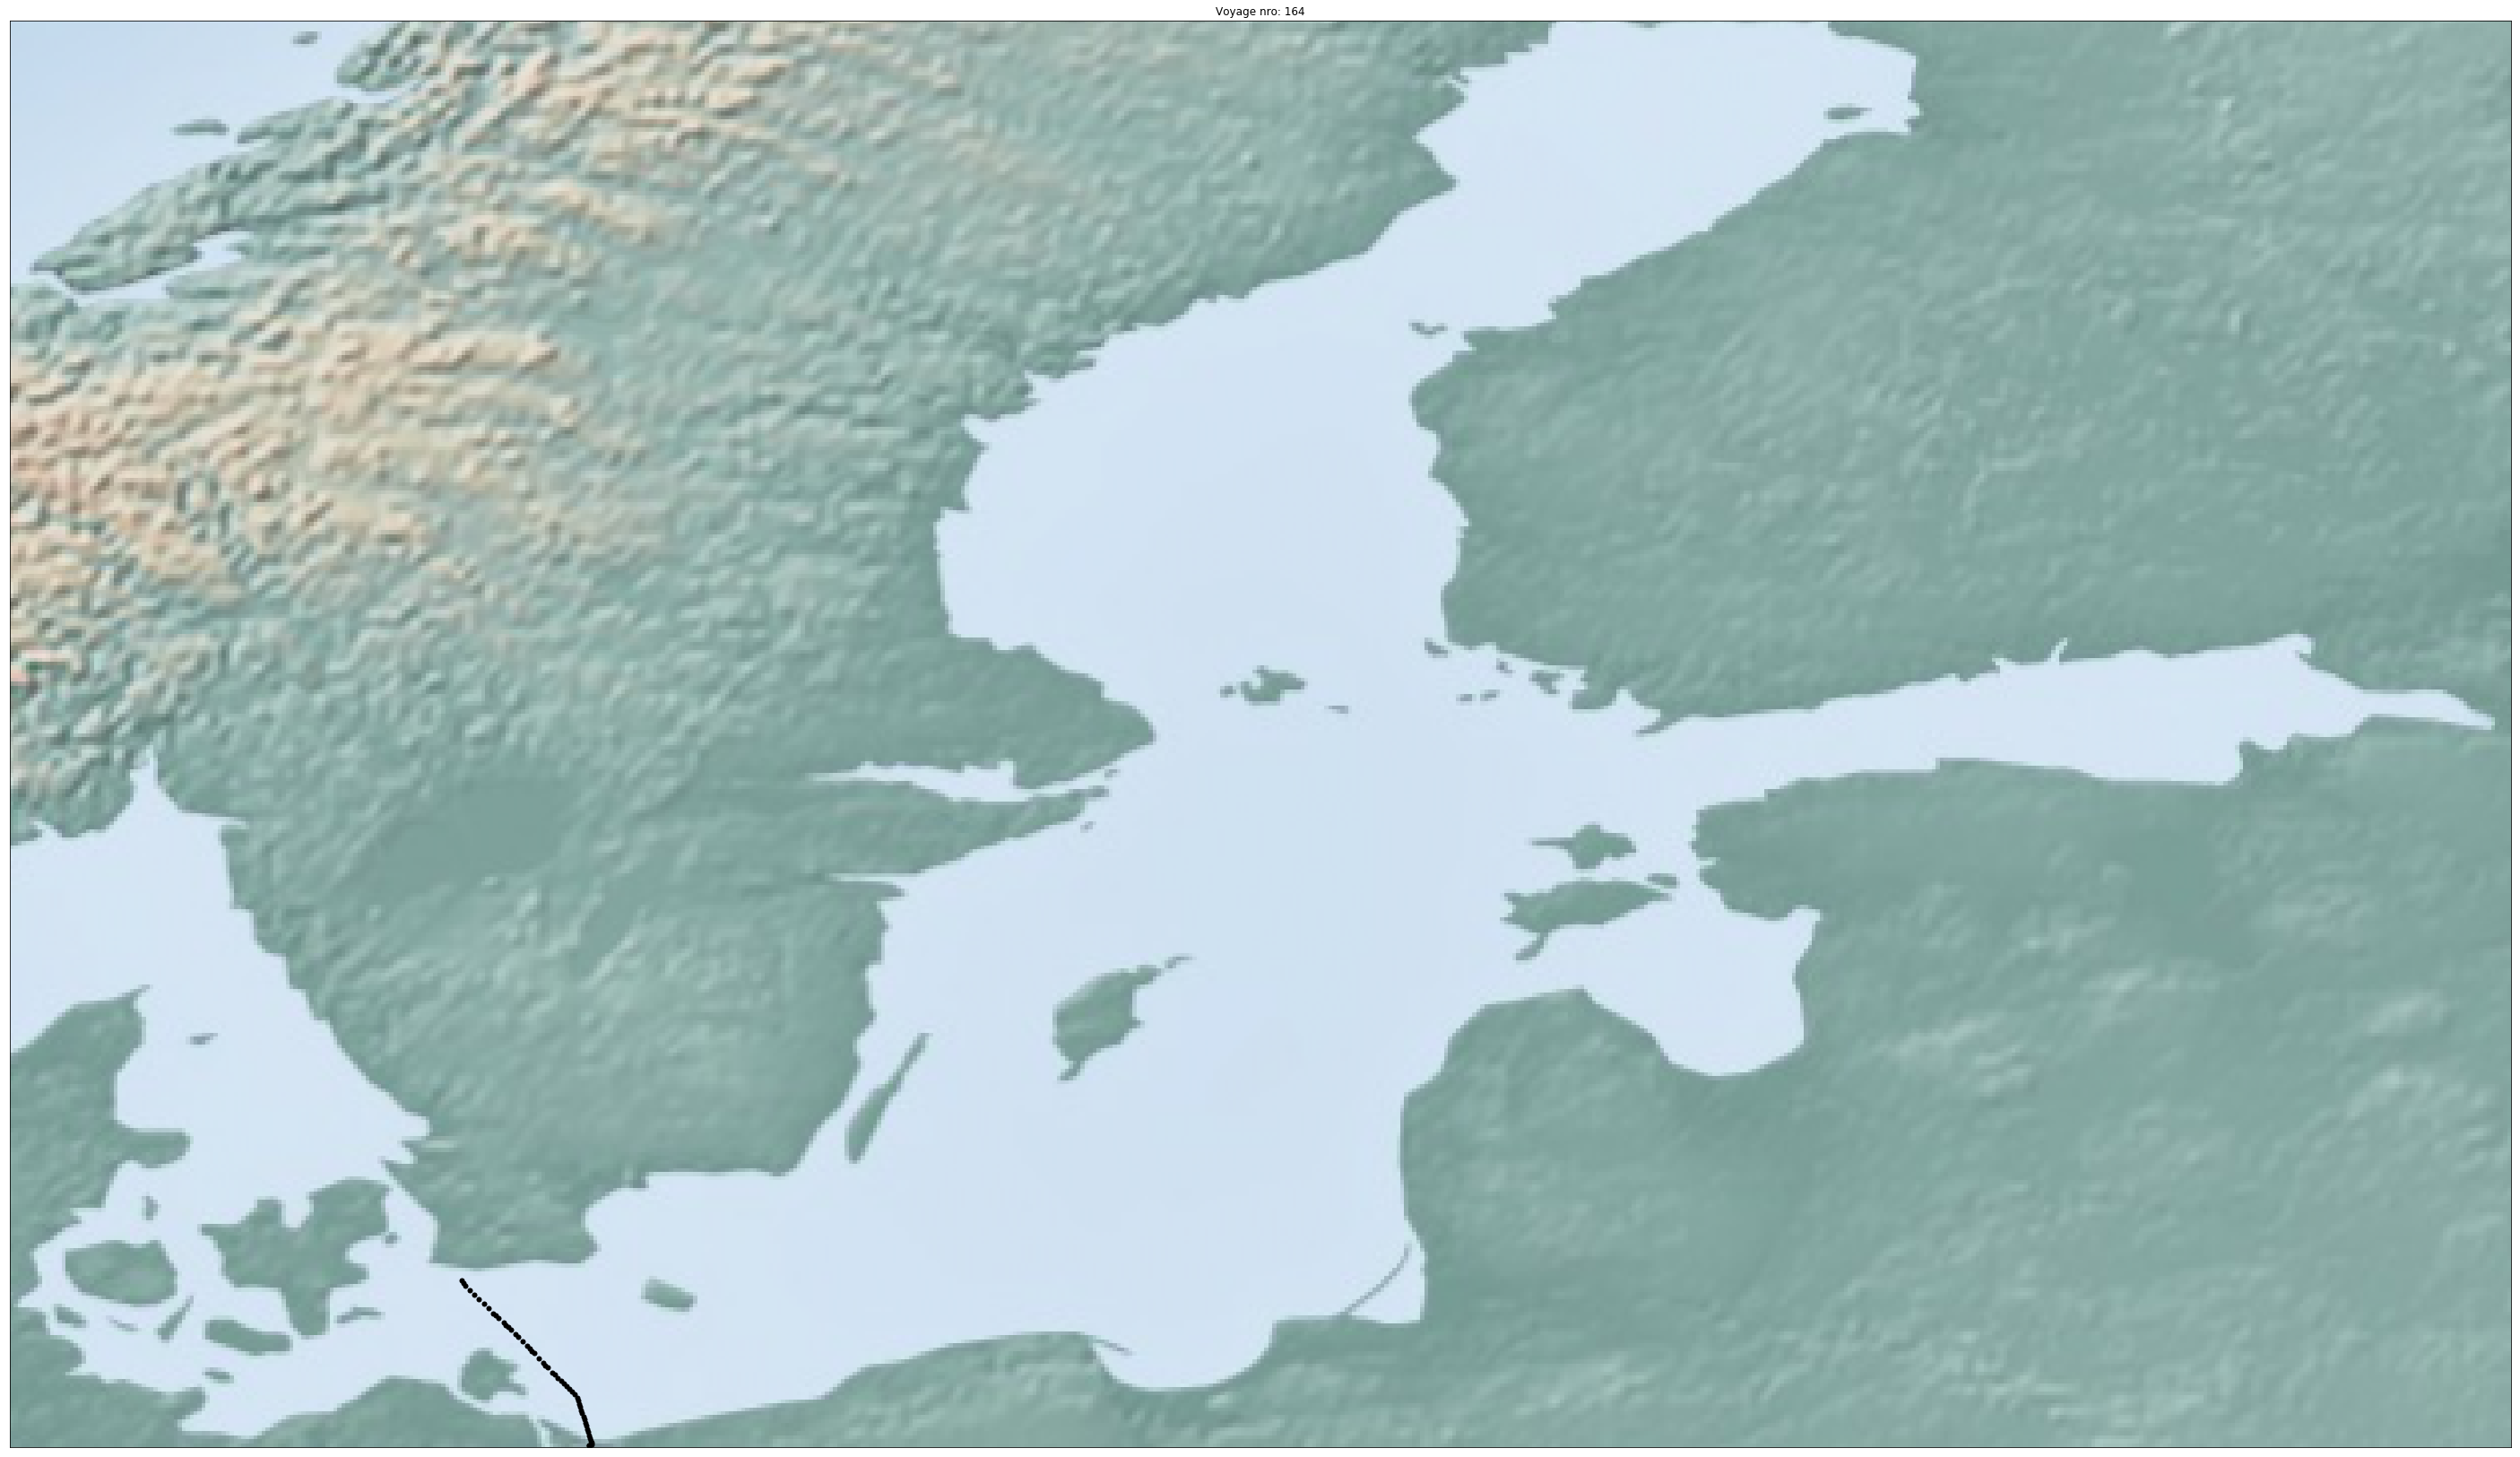

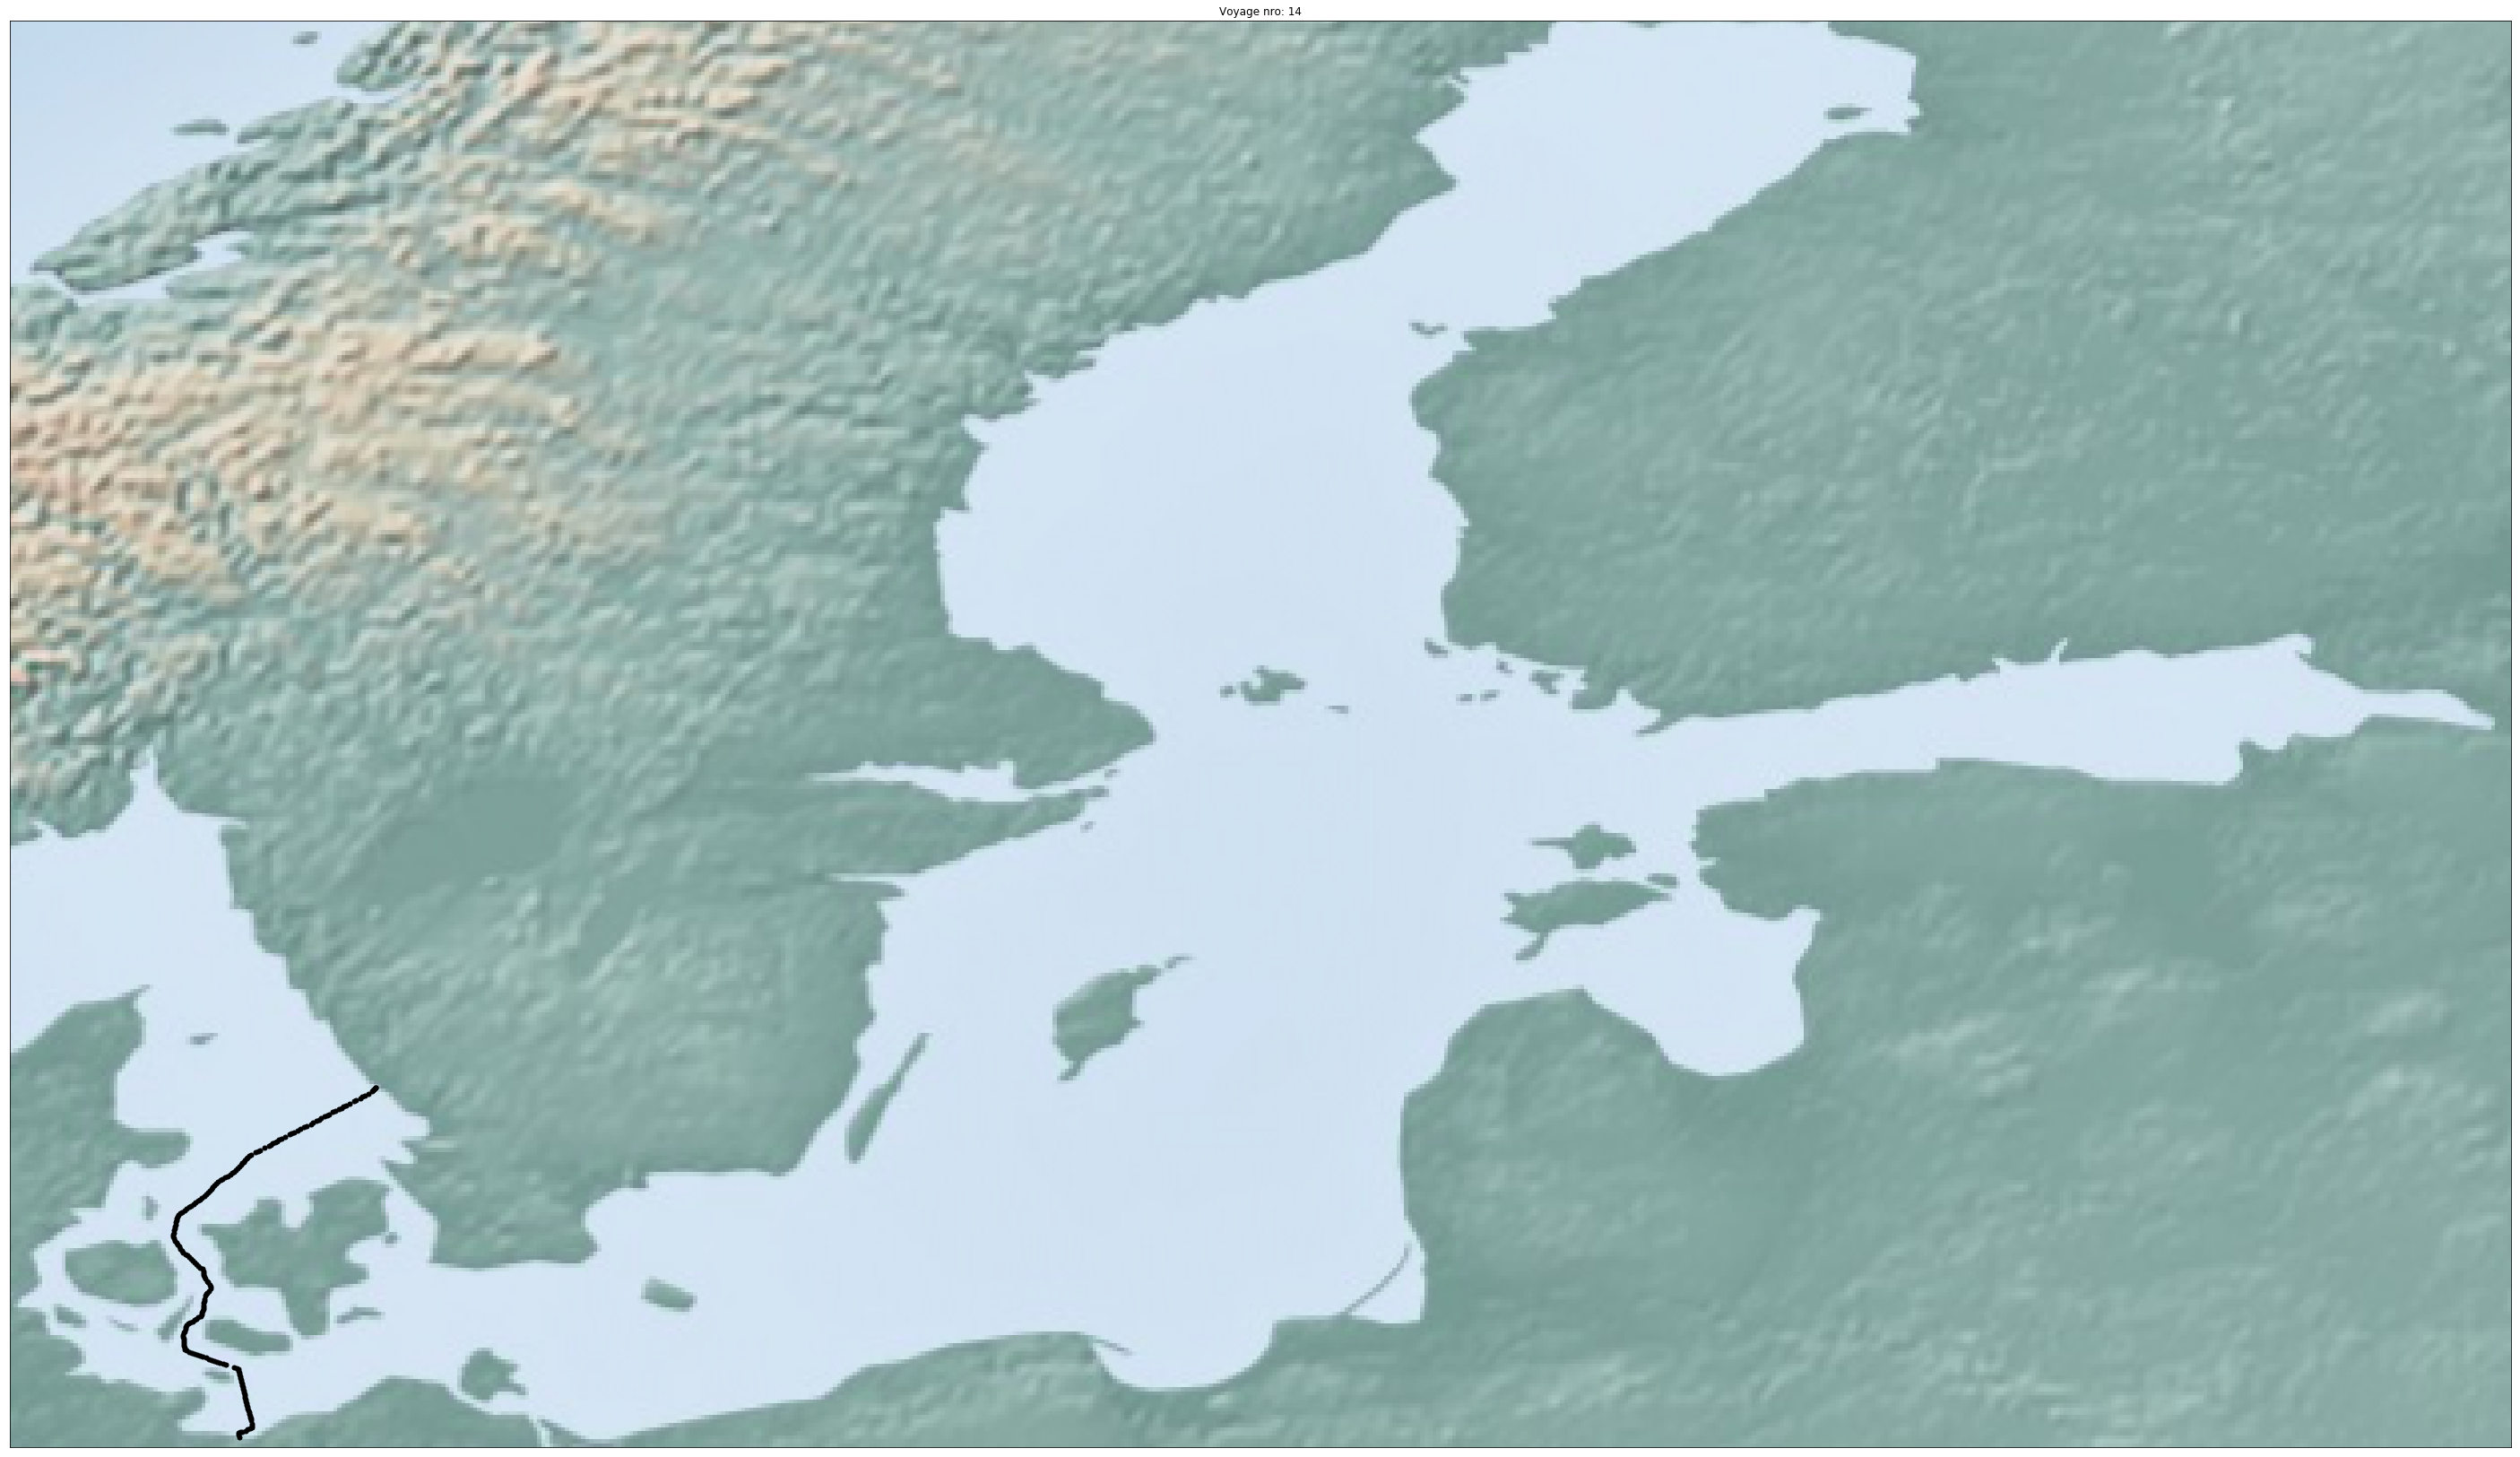

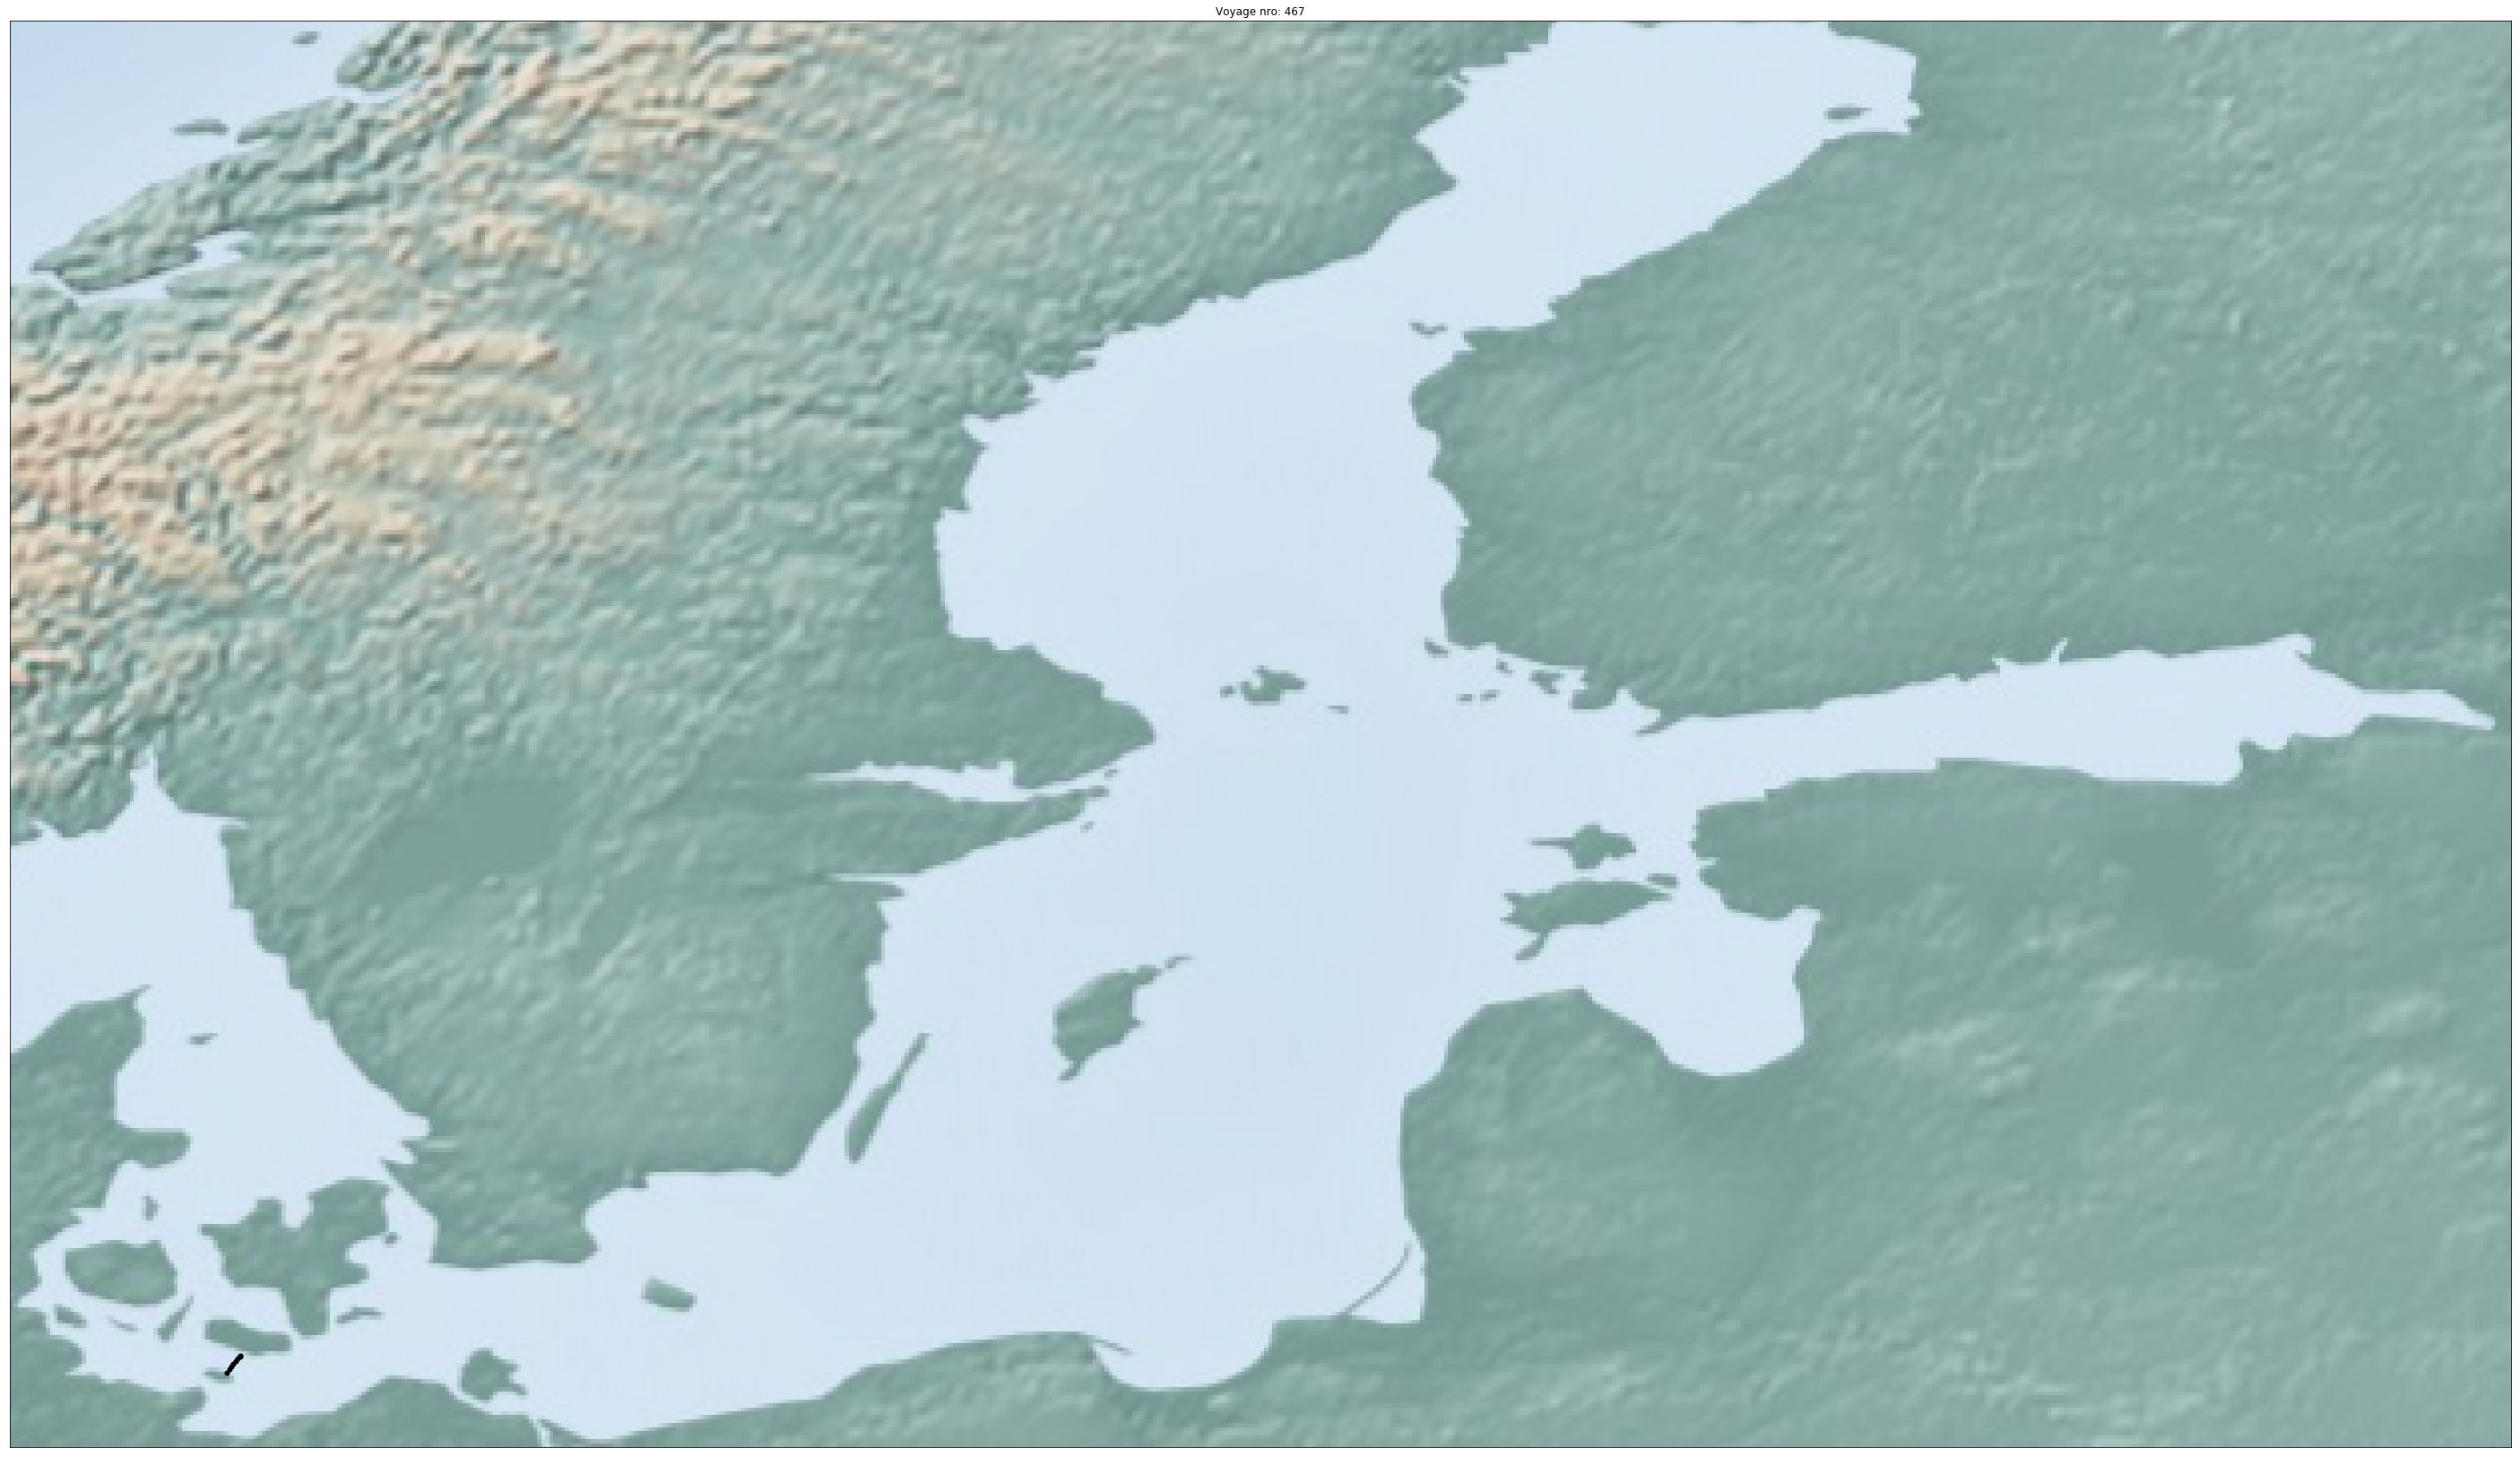

In [50]:
# Visualize routes with big differences
#voyages_with_differences = df_summer[(df_summer.difference < 100)].voyage.values

voyages_with_differences = df_winter[(df_winter.difference > 100)].sort_values(by=['difference']).tail(5).voyage.values

for voyage in voyages_with_differences:
    plot_route(test_voyages_summer, voyage)

In [74]:
winter_test_voyages = df_winter[~df_winter.voyage.isin(remove_winter)]
winter_test_voyages = winter_test_voyages[~winter_test_voyages.voyage.isin(remove_winter_short)]
winter_test_voyages = winter_test_voyages[~winter_test_voyages.voyage.isin([18])]
winter_test_voyages.head()

voyage  voyage_length  start_end_length  difference  travel_time  \
0       5     566.226600        457.635693   23.728680  2009.983333   
2      15    1688.687769       1363.525545   23.847168  3722.383333   
3      16    1616.150248       1360.454315   18.794893  3782.050000   
5      21     917.989518        704.429716   30.316694  2128.950000   
6      43    1672.891793       1363.551505   22.686366  4098.350000   

  vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
0          GC   4.771630  61.622468  17.207792  65.234498  21.628285   
2        CONT   7.548581  65.228732  21.636852  54.365267  10.144437   
3        CONT   7.125145  65.223325  21.606727  54.374755  10.177130   
5        CONT   7.232079  65.221242  21.649622  59.162025  17.663345   
6        CONT   6.886777  65.228953  21.636617  54.365450  10.143257   

   start_port  end_port  
0     3012222       935  
2         935      6652  
3         935      6652  
5         935     30775  
6         935      6652

In [75]:
winter_test_voyages['sea_area'] = winter_test_voyages.apply(lambda row: get_sea_area(sea_areas, row.end_lat, row.end_lon), axis=1)
winter_test_voyages['sea_area_name'] = winter_test_voyages.apply(lambda row: get_sea_area_name(sea_areas, row.end_lat, row.end_lon), axis=1)

winter_test_voyages.head(10)

voyage  voyage_length  start_end_length  difference  travel_time  \
0        5     566.226600        457.635693   23.728680  2009.983333   
2       15    1688.687769       1363.525545   23.847168  3722.383333   
3       16    1616.150248       1360.454315   18.794893  3782.050000   
5       21     917.989518        704.429716   30.316694  2128.950000   
6       43    1672.891793       1363.551505   22.686366  4098.350000   
7       44    1623.395902       1363.430468   19.067011  4197.800000   
8       46     112.534701        102.284130   10.021663   333.466667   
9       47     214.890821        130.502015   64.664753   844.333333   
10      62     953.479734        891.214544    6.986555  2510.350000   
11      63     964.834425        888.768670    8.558555  2876.033333   

   vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
0           GC   4.771630  61.622468  17.207792  65.234498  21.628285   
2         CONT   7.548581  65.228732  21.636852  54.365267  10.144437   
3         CONT   7.125145  65.223325  21.606727  54.374755  10.177130   
5         CONT   7.232079  65.221242  21.649622  59.162025  17.663345   
6         CONT   6.886777  65.228953  21.636617  54.365450  10.143257   
7         CONT   6.512199  65.226687  21.640660  54.365283  10.144435   
8         CONT   5.595938  64.998512  25.414152  65.754118  24.154917   
9         CONT   4.272119  65.739587  24.159533  65.236963  21.602927   
10          GC   6.348611  57.683303  18.966820  65.547485  22.250462   
11          GC   5.599924  65.528380  22.331773  57.709728  18.808443   

    start_port  end_port  sea_area           sea_area_name  
0      3012222       935         1            Bothnian Bay  
2          935      6652        -1                   Other  
3          935      6652        -1                   Other  
5          935     30775         6  Northern Baltic Proper  
6          935      6652        -1                   Other  
7          935      6652        -1                   Other  
8         1027      1073         1            Bothnian Bay  
9         1073       935         1            Bothnian Bay  
10        1053       999         1            Bothnian Bay  
11         999      1053         8   Eastern Gotland Basin

In [76]:
len(winter_test_voyages)

82

In [77]:
winter_test_voyages[['sea_area_name', 'sea_area']].drop_duplicates()

sea_area_name  sea_area
0             Bothnian Bay         1
2                    Other        -1
5   Northern Baltic Proper         6
11   Eastern Gotland Basin         8
12            Bothnian Sea         3
13            Gulf of Riga         7
26   Western Gotland Basin         9
37         Gulf of Finland         5
55               The Quark         2

In [78]:
winter_test_voyages[['sea_area_name', 'sea_area']].groupby('sea_area_name').count()

sea_area
sea_area_name                   
Bothnian Bay                  39
Bothnian Sea                   9
Eastern Gotland Basin          1
Gulf of Finland                3
Gulf of Riga                   2
Northern Baltic Proper         1
Other                         21
The Quark                      2
Western Gotland Basin          4

In [79]:
validation_set_voyages_winter = winter_test_voyages.head(0)
validation_set_voyages_winter = validation_set_voyages_winter[~validation_set_voyages_winter.voyage.isin([18])].append(winter_test_voyages.sample(n=80))

print(len(validation_set_voyages_winter.voyage))
#validation_set_voyages_winter[validation_set_voyages_winter.sea_area == 13].head()
validation_set_voyages_winter.head()

80


voyage  voyage_length  start_end_length  difference  travel_time  \
10      62     953.479734        891.214544    6.986555  2510.350000   
47     369     563.622619        495.323756   13.788731  1798.166667   
15      97    1834.982705       1132.951521   61.964803  6673.816667   
34     224     568.474037        476.277709   19.357683  2070.633333   
54     395    1674.517523       1455.283645   15.064684  4576.166667   

   vessel_type  avg_speed  start_lat  start_lon    end_lat    end_lon  \
10          GC   6.348611  57.683303  18.966820  65.547485  22.250462   
47          GC   5.240836  65.744373  24.156978  62.406053  17.394552   
15          GC   4.568775  57.478537  11.502415  65.751898  24.156347   
34          GC   4.575784  65.664915  24.511200  61.596052  21.489665   
54          GC   6.103234  65.731260  23.383568  54.365727  10.143432   

    start_port  end_port  sea_area sea_area_name  
10        1053       999         1  Bothnian Bay  
47        1073      1061         3  Bothnian Sea  
15       24627      1073         1  Bothnian Bay  
34         969      1011         3  Bothnian Sea  
54         959      6652        -1         Other

In [82]:
validation_set_winter = winter_filtered[winter_filtered.voyage.isin(validation_set_voyages_winter.voyage.values)]
validation_set_winter.voyage.drop_duplicates().describe()
validation_set_winter['end_port_sea_area'] = validation_set_winter.apply(lambda row: get_sea_area(sea_areas, row.end_lat, row.end_lon), axis=1)
#validation_set_winter.to_csv('validation_set_winter_complete_extended.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
for iceclass, iceclass_results in validation_set_winter.groupby('iceclass'):
    print(iceclass)

IA
IAS


In [81]:
validation_set_winter[validation_set_winter.voyage == 18]

Empty DataFrame
Columns: [timestamp, mmsi, lat, lon, speed, node, vessel_type, iceclass, start_port, end_port, end_lat, end_lon, ata, atd, in_port, voyage, course, end_port_sea_area]
Index: []

In [71]:
validation_set_winter[validation_set_winter.speed > 3].speed.mean()

6.4861041867241065

In [29]:
#winter_filtered.to_csv('test_set_winter_voyages_filtered.csv')

In [81]:
wint_orig_len = len(test_voyages_winter.voyage.drop_duplicates())
sum_orig_len = len(test_voyages_summer.voyage.drop_duplicates())

filt_wint_len = len(winter_filtered.voyage.drop_duplicates())
filt_sum_len = len(summer_filtered.voyage.drop_duplicates())

(((wint_orig_len - filt_wint_len) + (sum_orig_len - filt_sum_len)) / (wint_orig_len + sum_orig_len)) * 100


16.529877609791217